## Analisis comparativo de precios mercado diario VS mercado intradiario

#### Cambios para esta version
 - Para los gráficos agregar el promedio de energía y no sumatoria
 - A la gráficas en cada punto agregarlo los desvíos estándar también como barritas
 - Agrega las diferencias vs el intradiario anterior
 - Para los mapas de calor, la barra de colores esta fijada de manera que todas representen la misma escala de valores

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.pardir, "../haitta_wind/src/w2m/data/")))
from w2m.data import data
sys.path.insert(0, os.path.abspath(os.path.join(os.pardir, "../haitta_wind/src/w2m/utils/")))
from w2m.utils import utils as ut
from statsmodels.tsa.seasonal import seasonal_decompose

/home/ifranco/projects/alsa/daver/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ifranco/projects/alsa/daver/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# DIRECTORIO DONDE SE ENCUENTRAN LOS ARCHIVOS DE w2m
raw_w2m_dir = '/media/sf_Shared/hAItta/w2m/'

Carga de los dataset a utilizar

In [3]:
df_pdbc = data.read_historic_pdbc(raw_w2m_dir)
df_pibc = data.read_historic_marginal_pibc(raw_w2m_dir)

# Los datos de este dataframe provienen de los ficheros Desvio_sistema_y_precios_mercados.xlsx y Datos_del_sistema.xlsx
df_info = pd.read_csv('df_desvio_precios_demandas_hueco.zip', compression='zip')

df = ut.make_prices_analysis_dataset(df_pdbc=df_pdbc, df_info=df_info, df_pibc=df_pibc)

AGGREGATIONS = {
    'energia':['mean', 'std'],
    'demanda_real':['mean', 'std'],
    'marginalES':['mean', 'std'],
    'pmd':['mean', 'std'],
    'diff_pmd_marginalES': ['mean', 'std'],
    'desvio_sistema':['mean', 'std'],
    'desvio_sistema_previsto_w2m_D-1':['mean', 'std'],
    'hueco_termico':['mean', 'std'],
    'hidraulica_eolica':['mean', 'std'],
    'energias_sin_comb_fosil':['mean', 'std'],
}

### Antes de observar las visualizaciones
  - La energia sera para todos los intradiarios la misma, dado que el nivel de agregacion de estos datos es a nivel de periodo y no de intradiario
  - En el eje X se encuentran los periodos
  - En el eje Y del lado derecho se encuentra la escala de Precio en euros
      - En verde el PMD (con una barra verde para los desvios)
      - En azul el precio del intradiario descripto 
  - En el eje Y del lado izquierdo se encuentra la escala de Energia en MWh (con una barra roja para los desvios)
  - En los mapas de calor, el valor representa 'cuanto mas arriba o mas abajo estuvo el el precio en el mercado intradiario en relacion a su intradiario anterior
  
 Vale aclarar que si bien esta agrupado por año, los datos utilizados corresponden a un año completo, desde el 05/2017 al 04/2018, ya que aunque los datos de precios marginales pibci sean desde 2013 a 2018, los datos de pdbc son desde 01/2017 a 08/2018, y los datos relacionados al PMD, desvios, hueco termico, etc, son desde 05/2017 al 04/2018 que al utilizar las fechas como indice, recortan el dataset.

En las siguientes agrupaciones, las agregaciones que se realizaran sobre los datos seran:
    - energia: media (serie), desvio (barra)
    - marginalES: media (serie), desvio (barra)
    - pmd: media (serie), desvio (barra)
    - diff_pmd_marginalES: media

## Agrupacion por mes - año - intradiario - periodo 

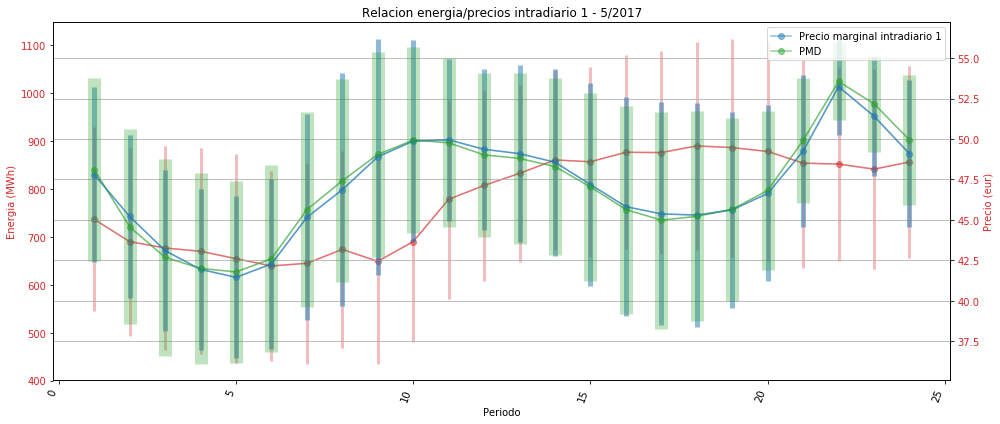

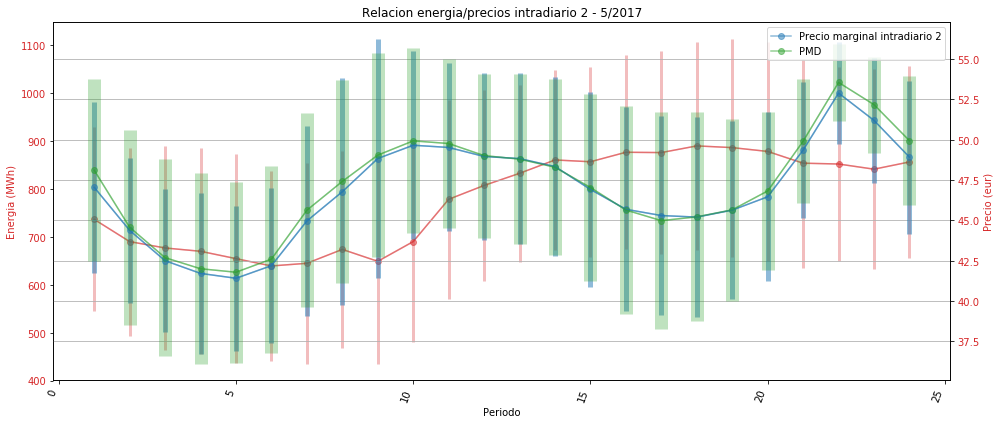

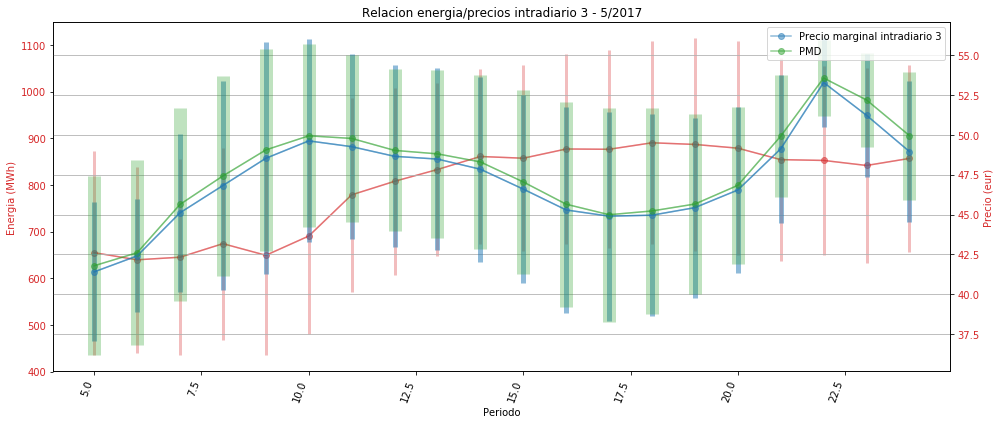

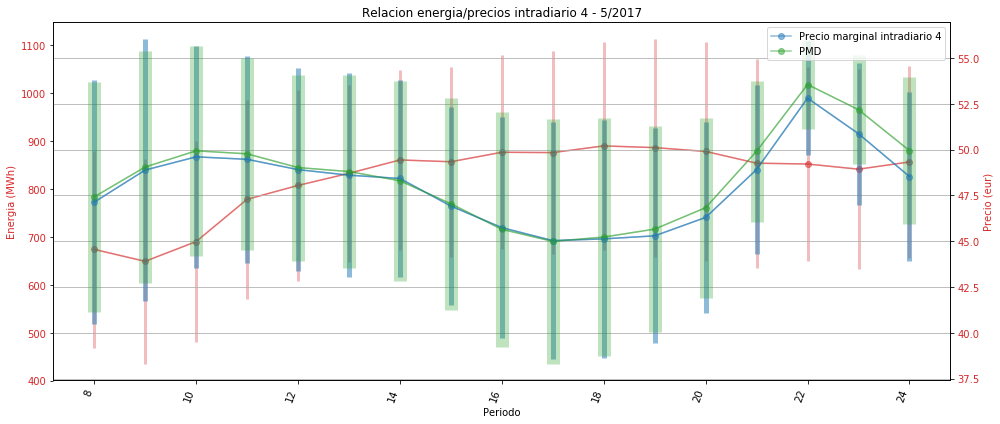

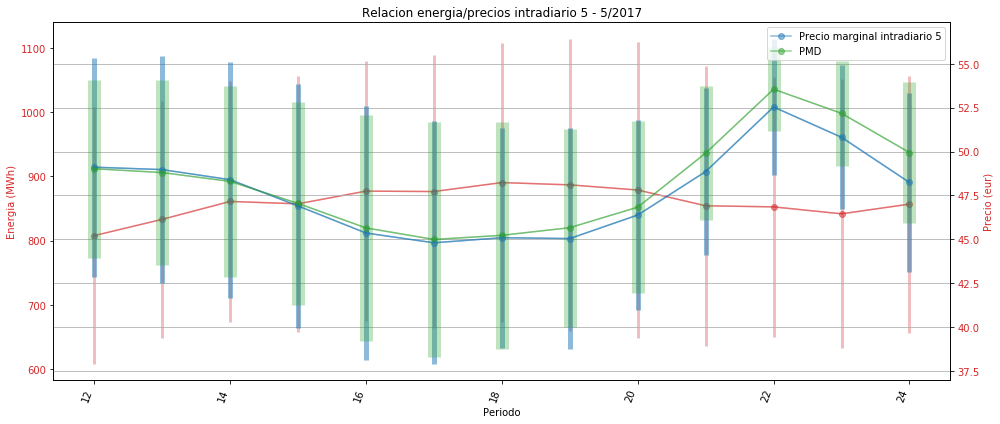

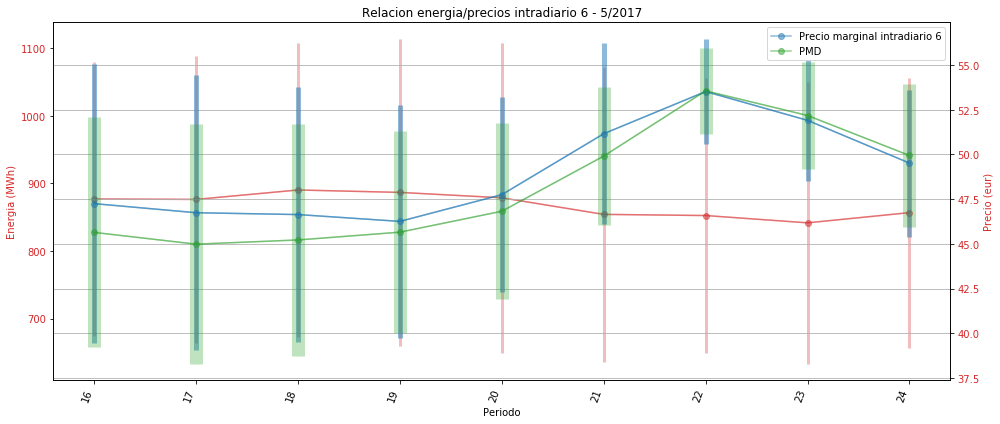

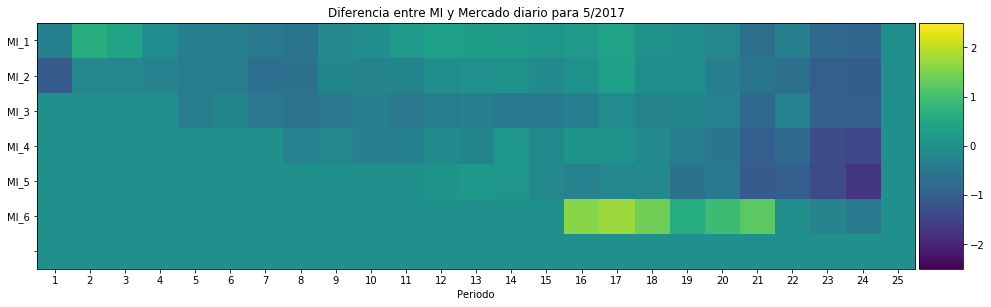

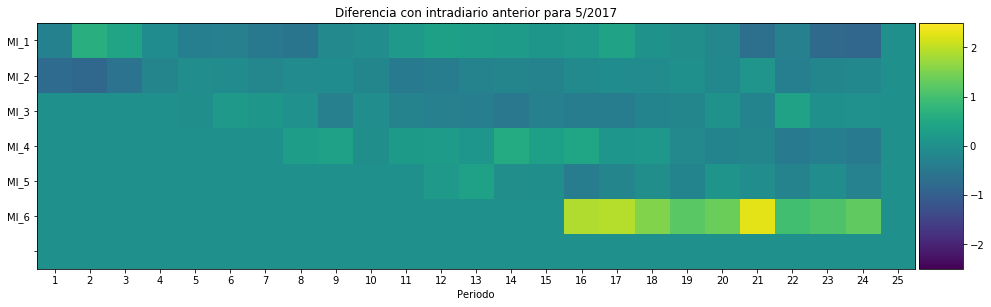

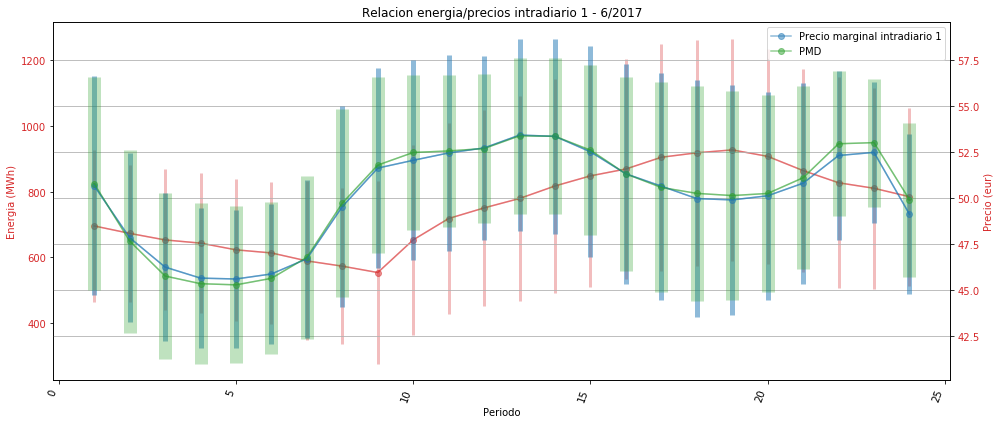

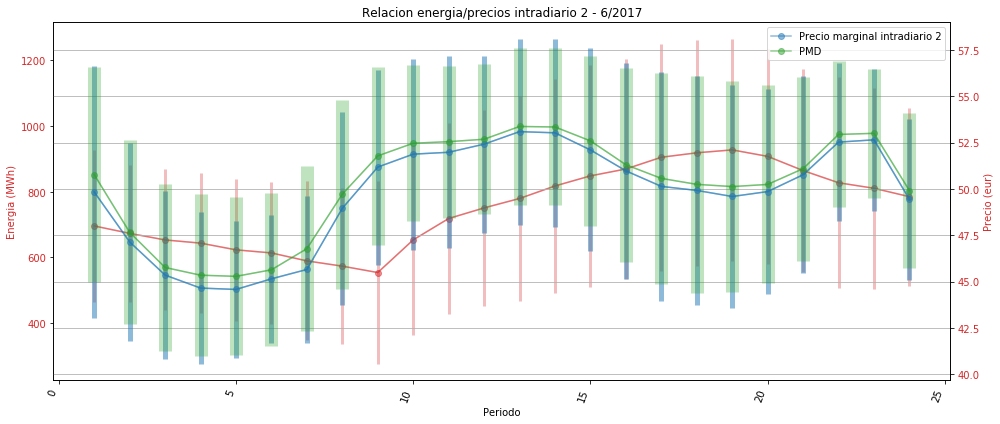

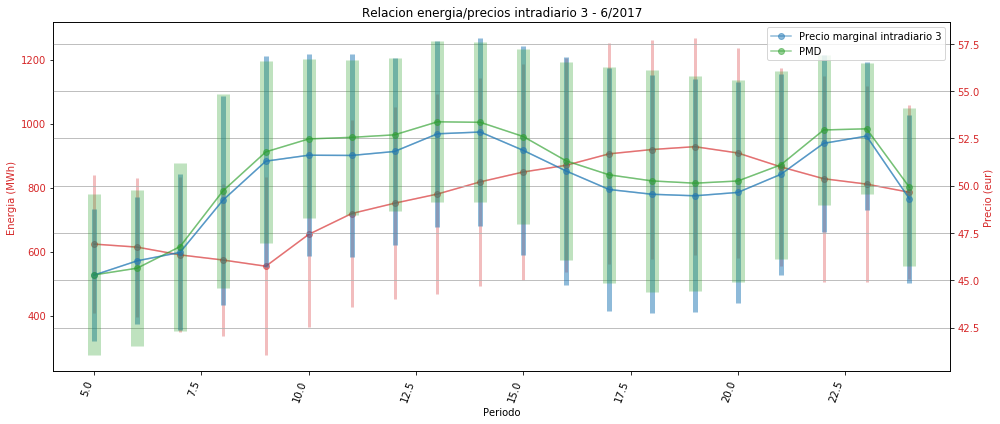

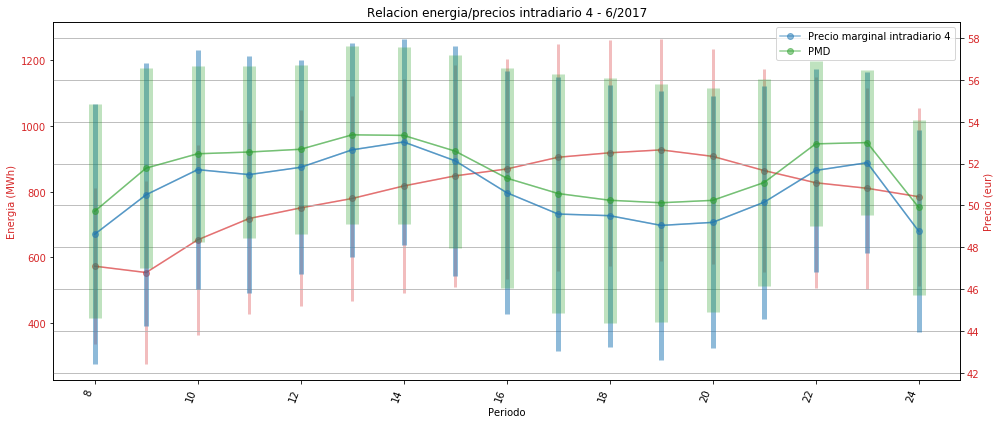

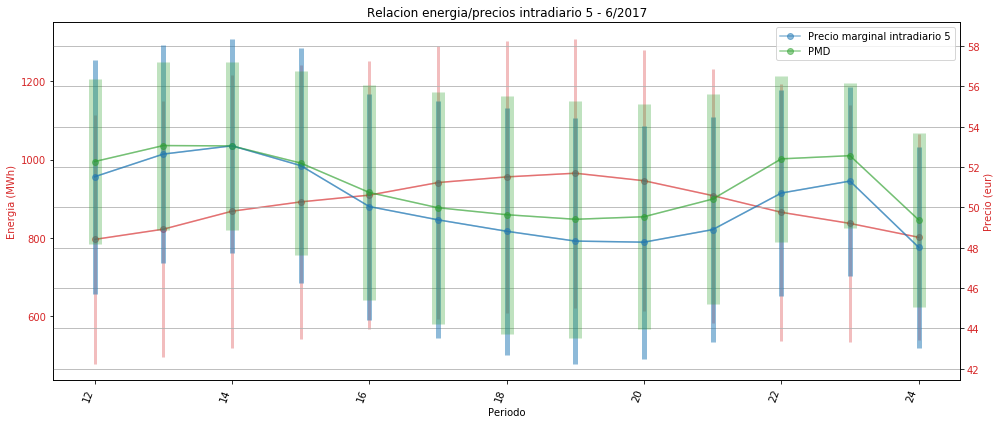

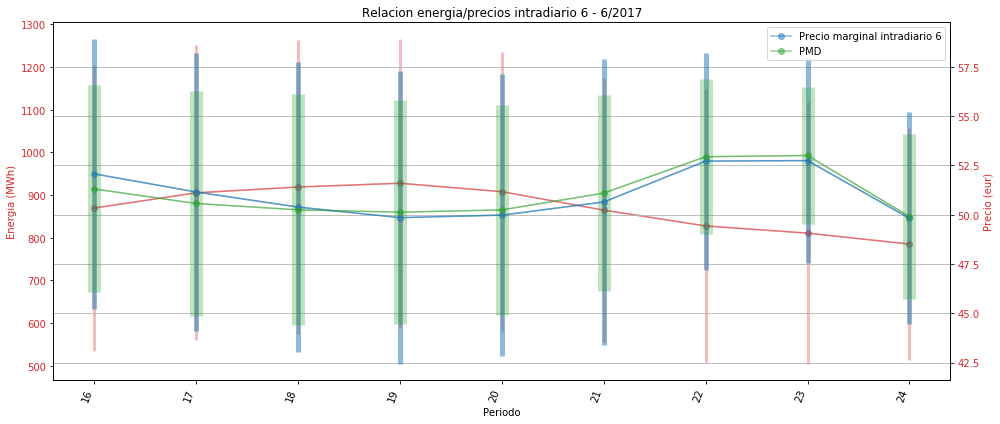

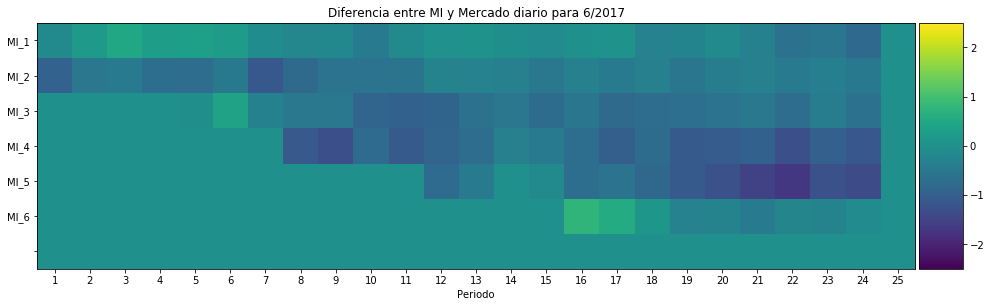

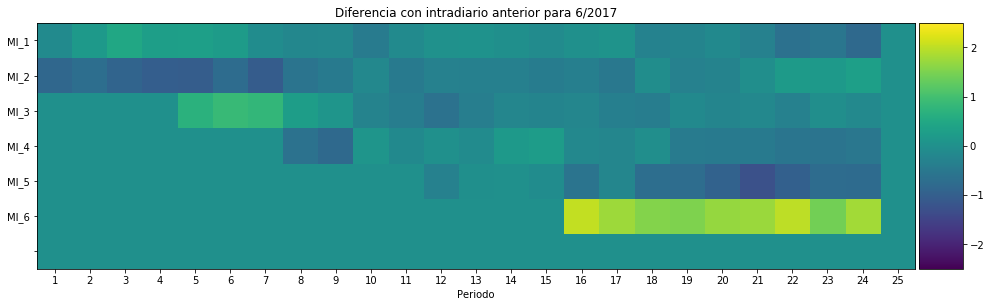

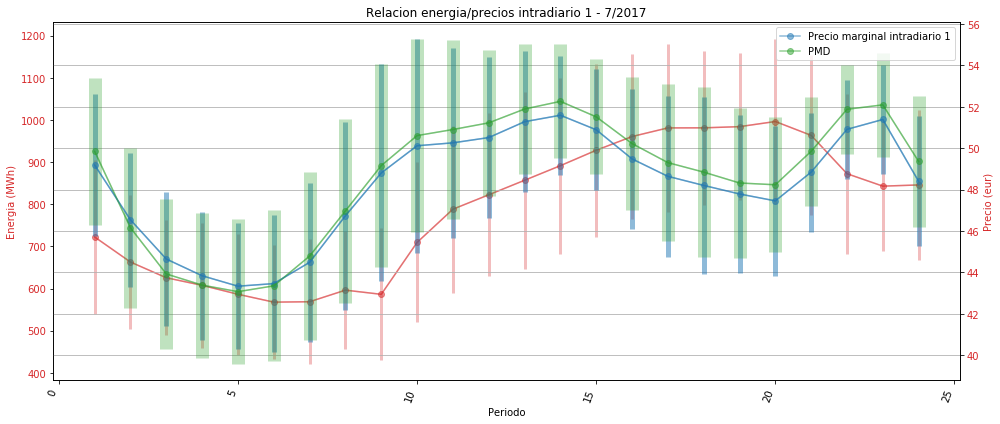

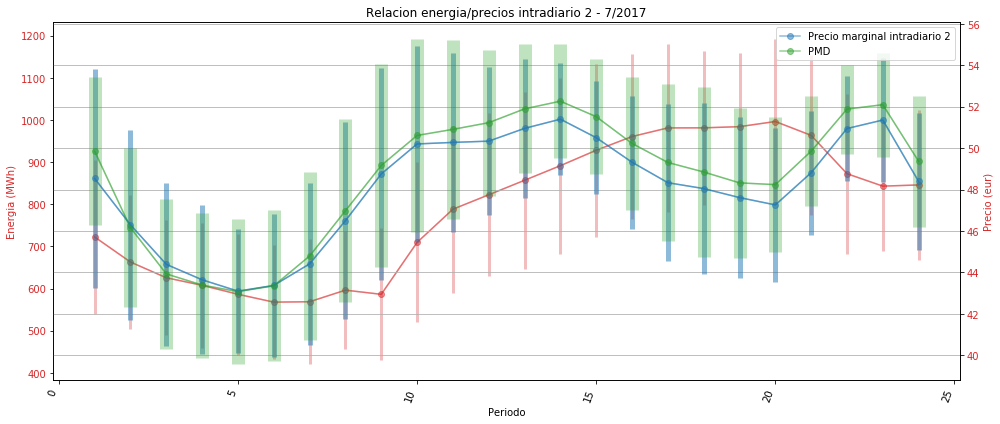

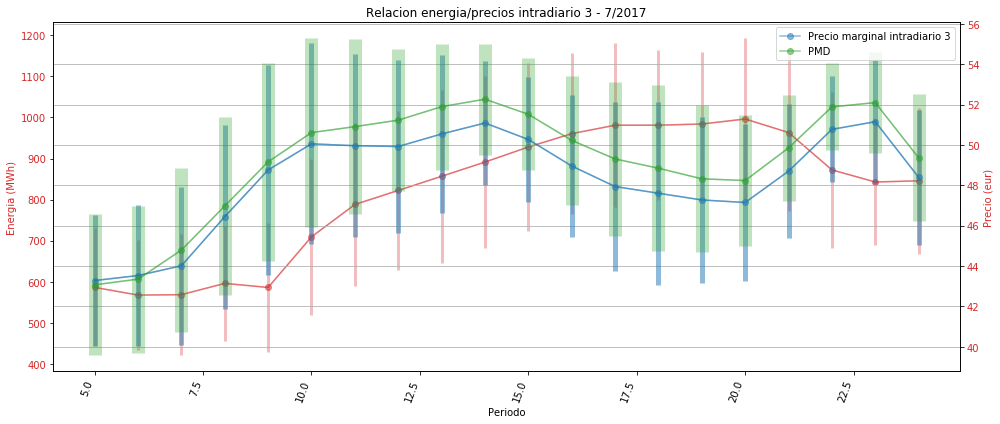

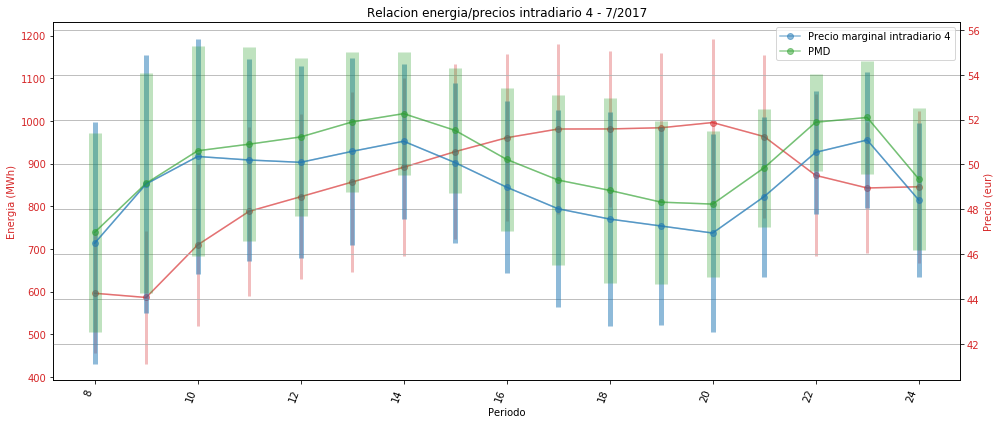

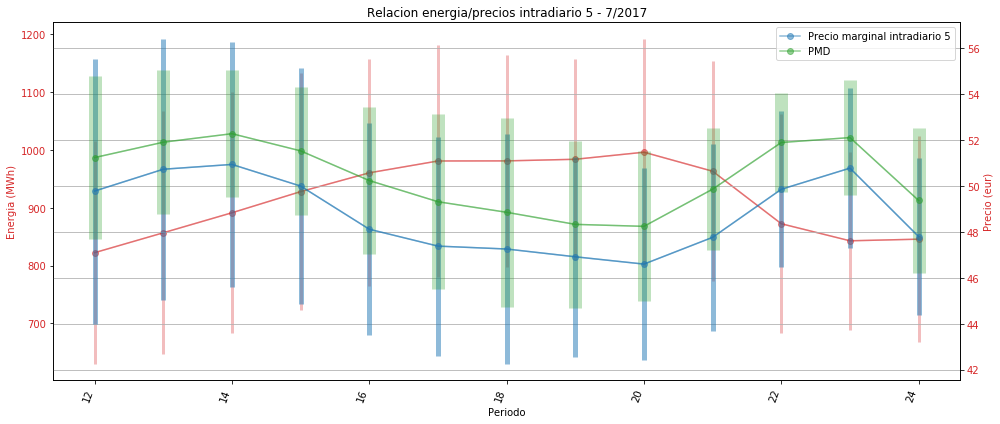

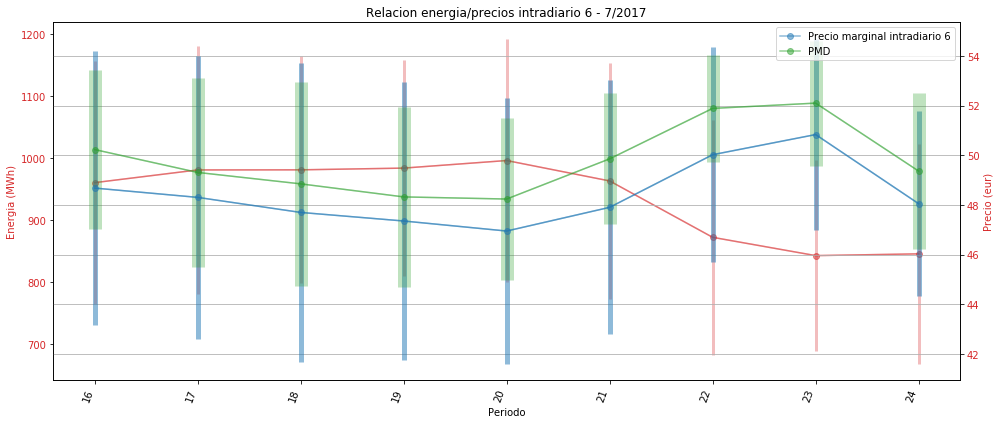

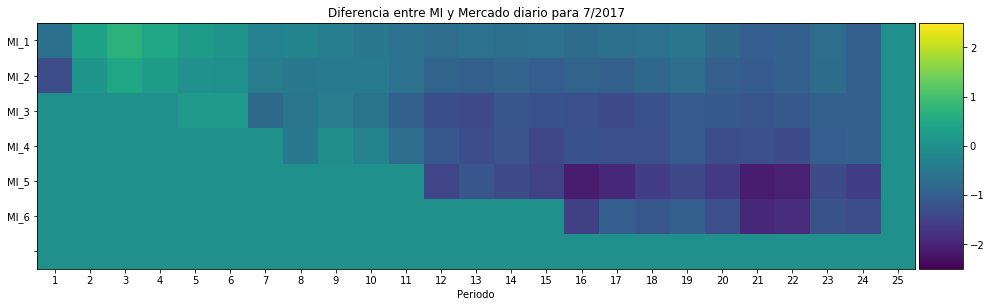

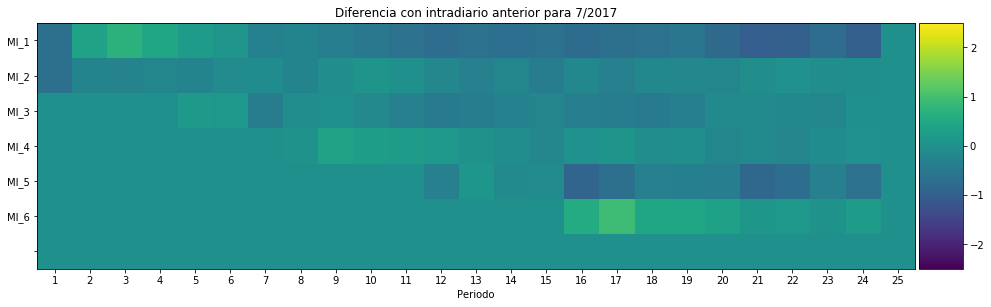

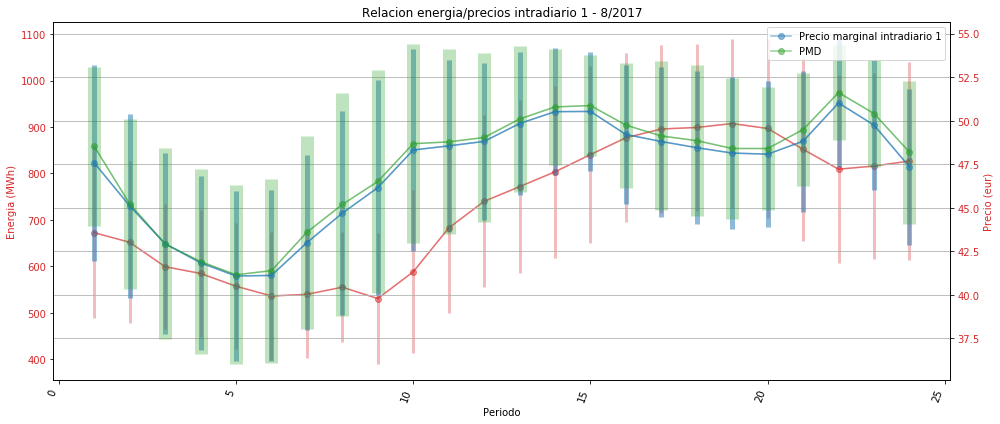

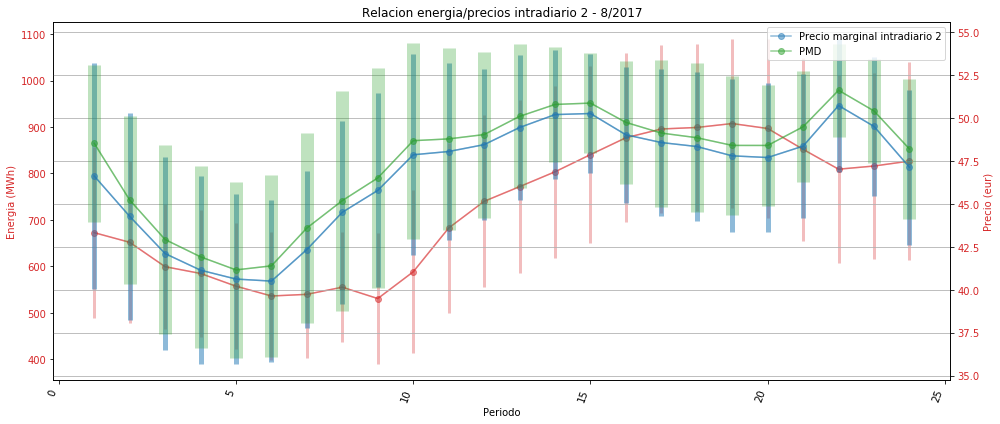

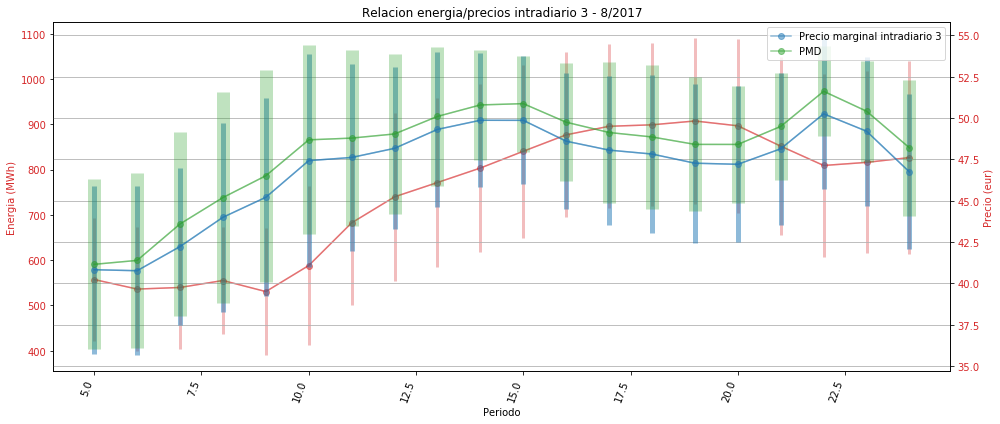

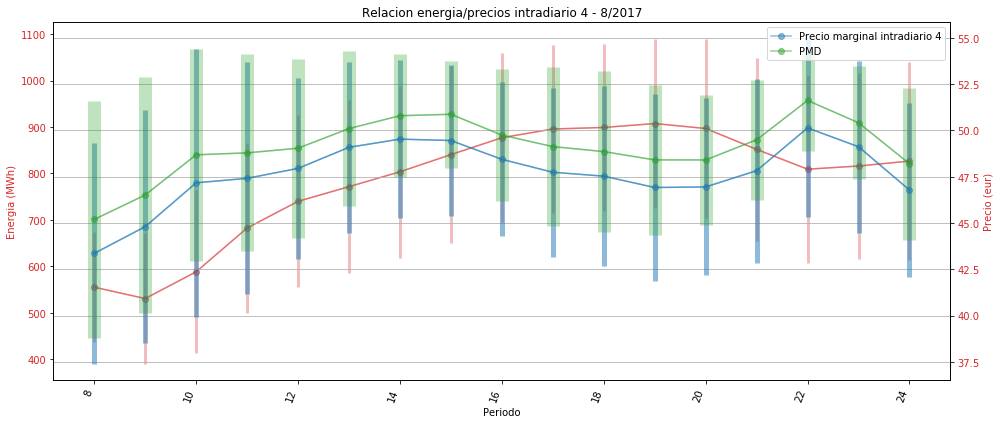

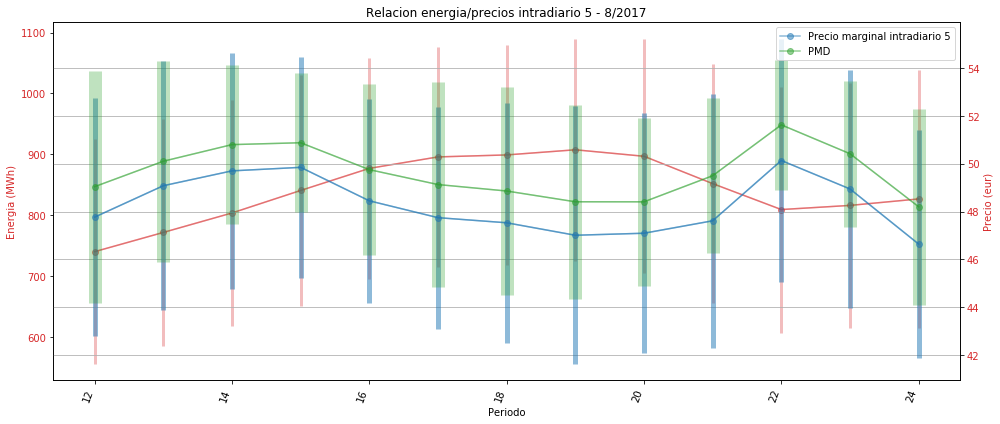

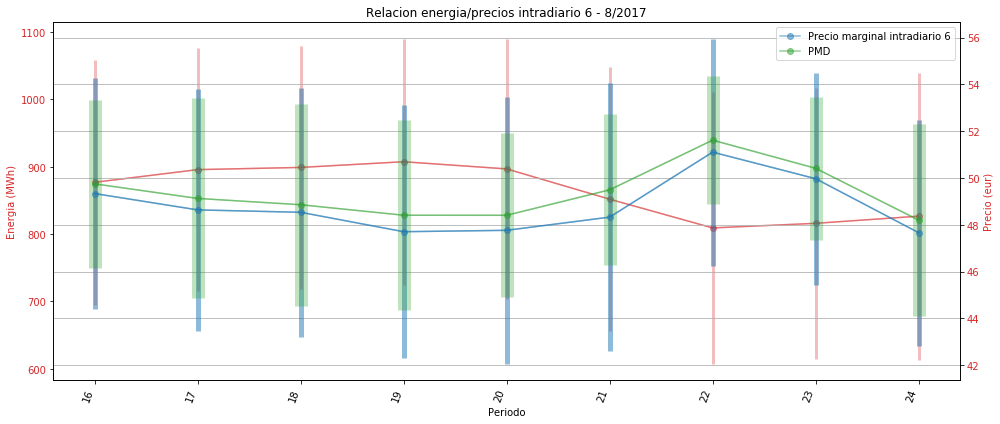

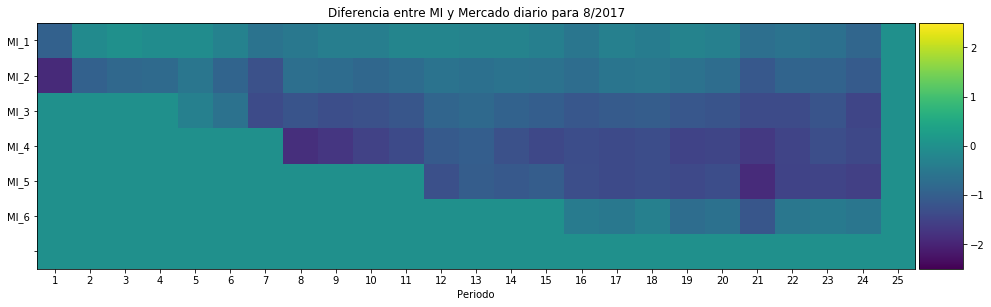

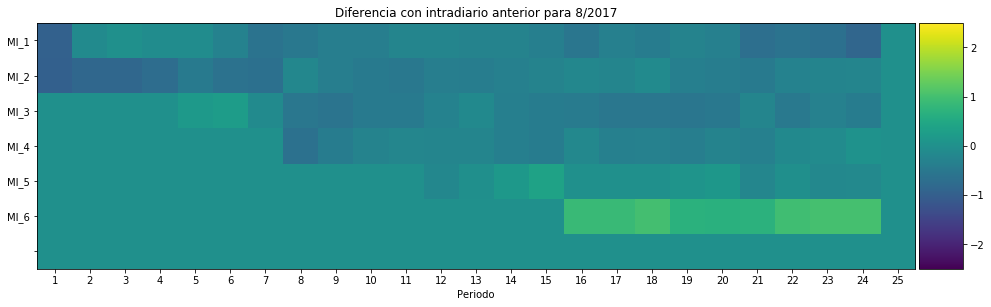

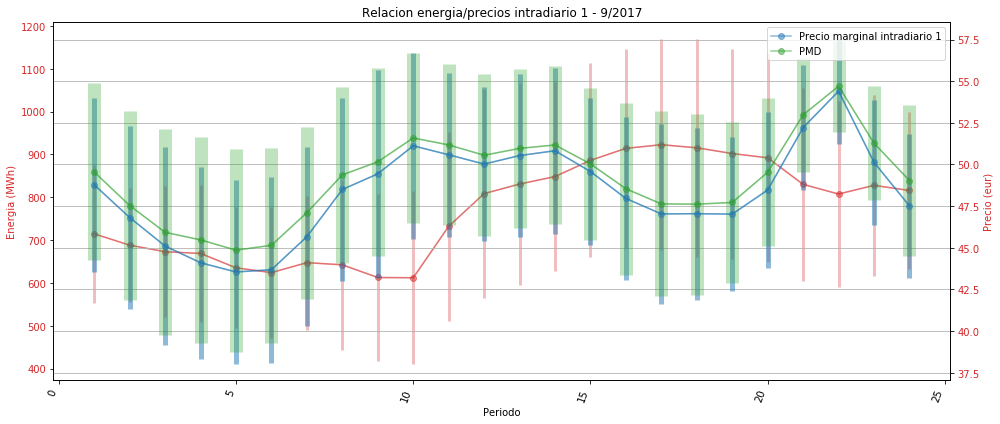

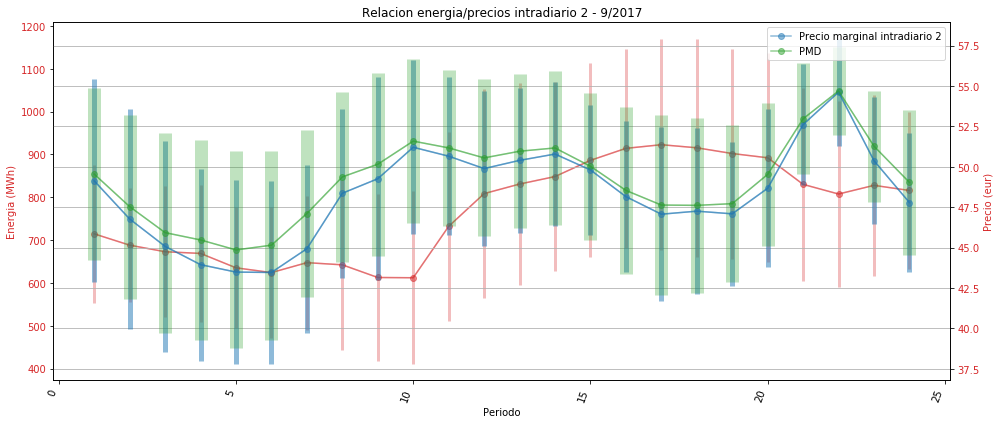

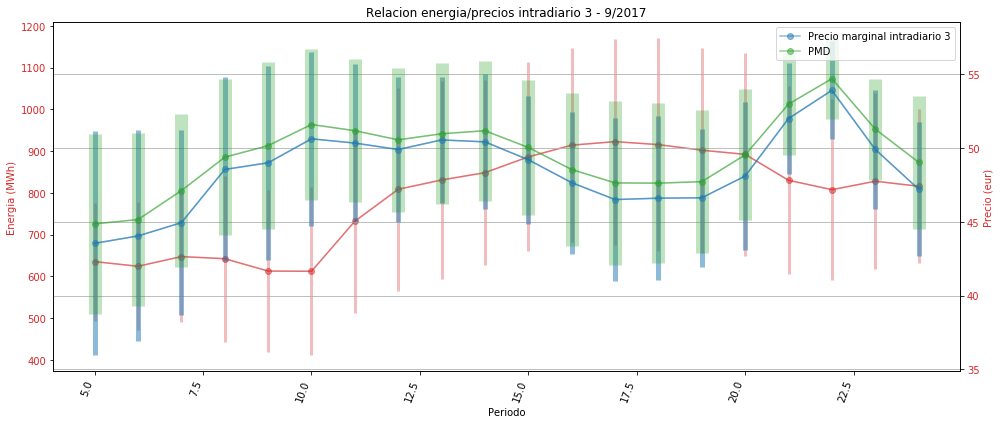

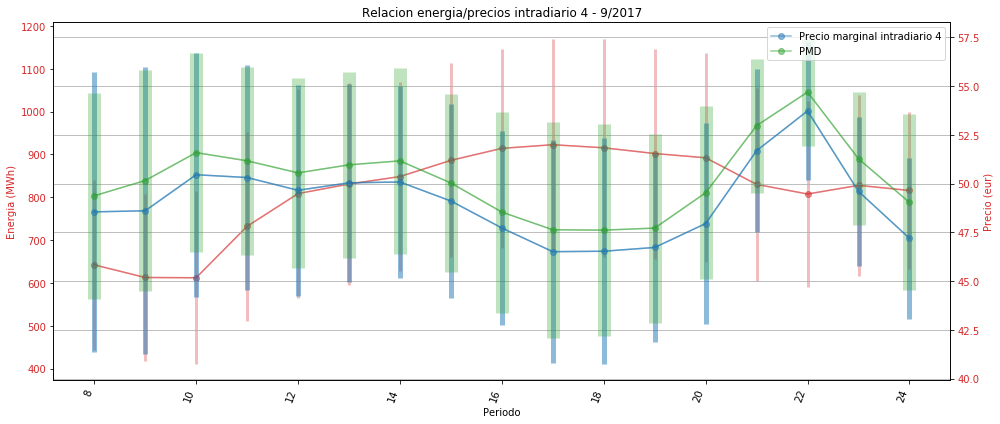

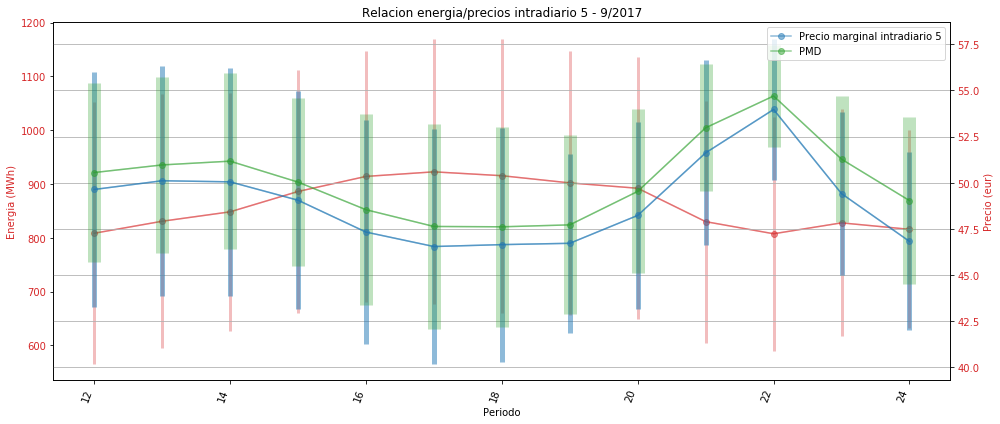

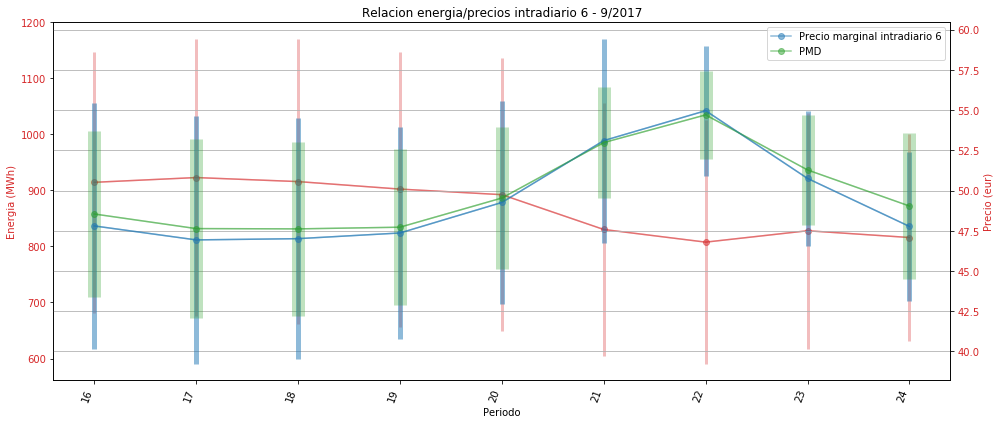

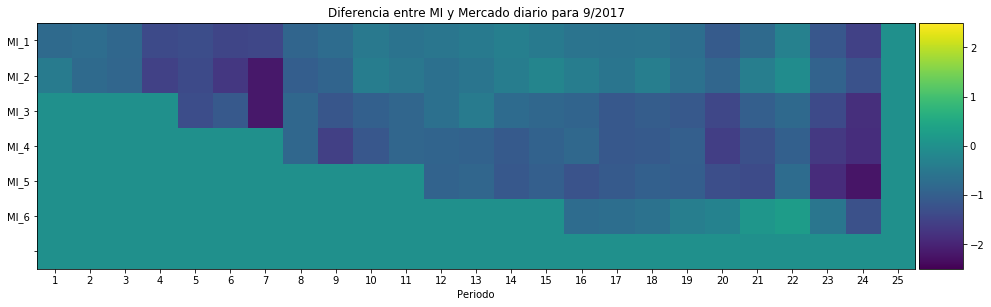

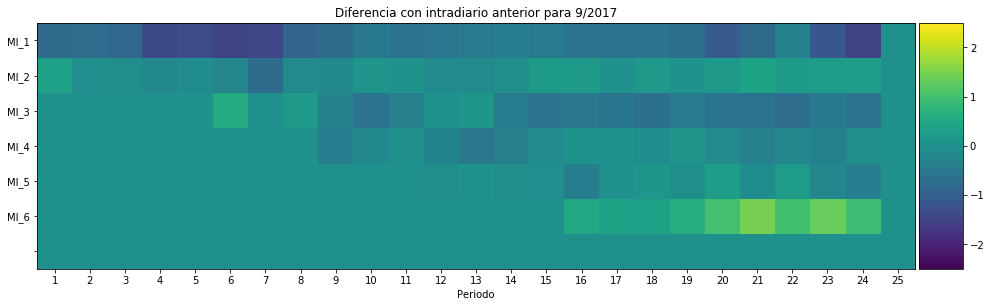

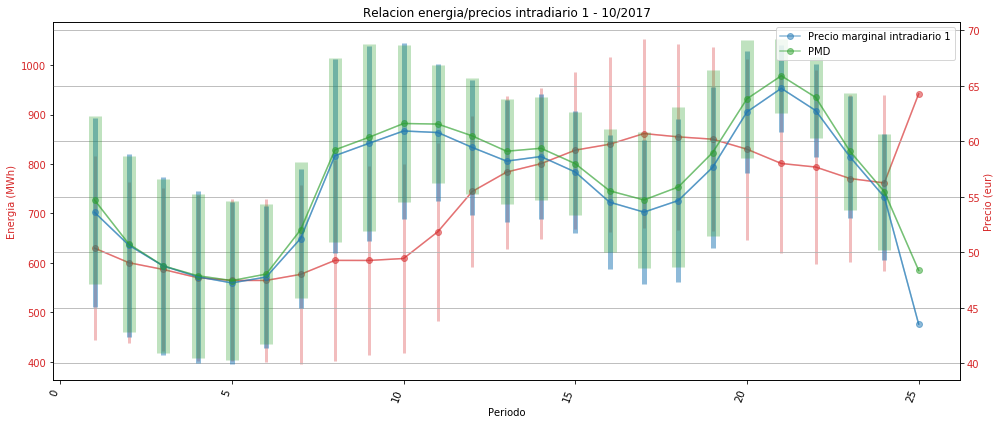

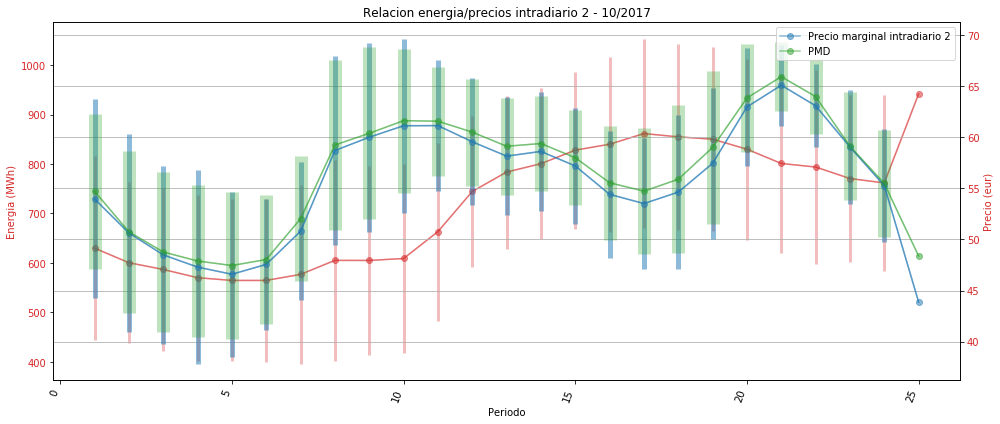

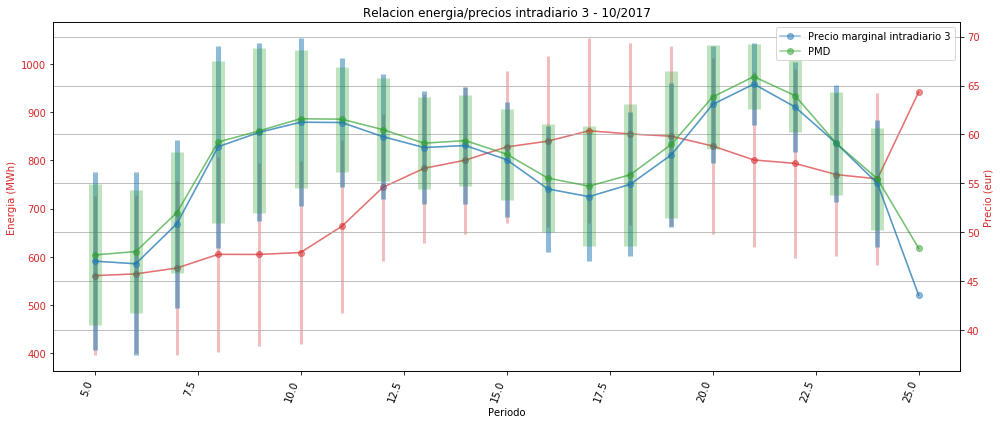

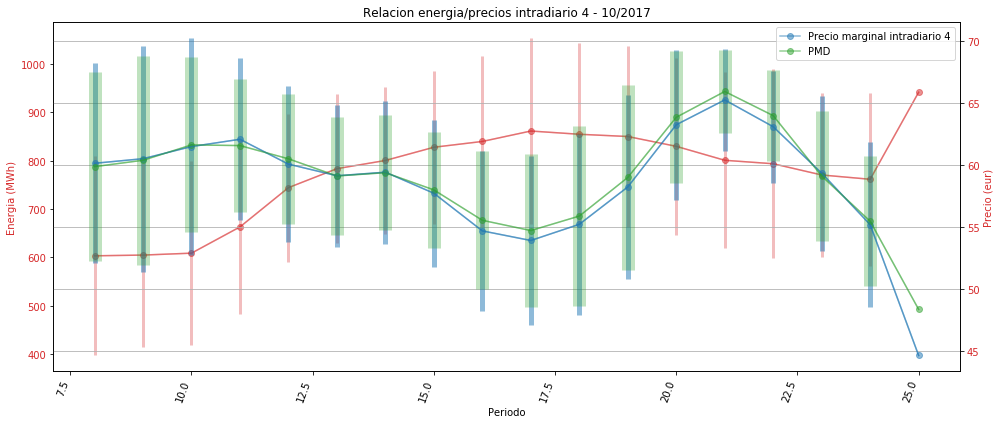

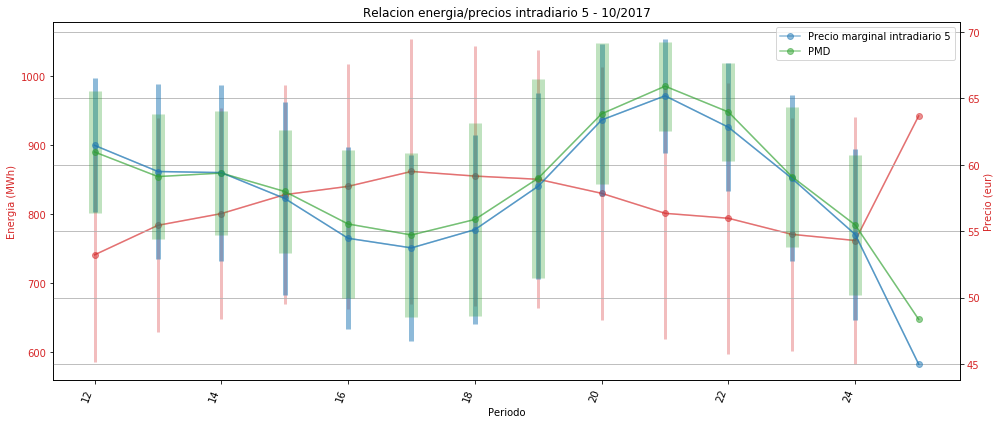

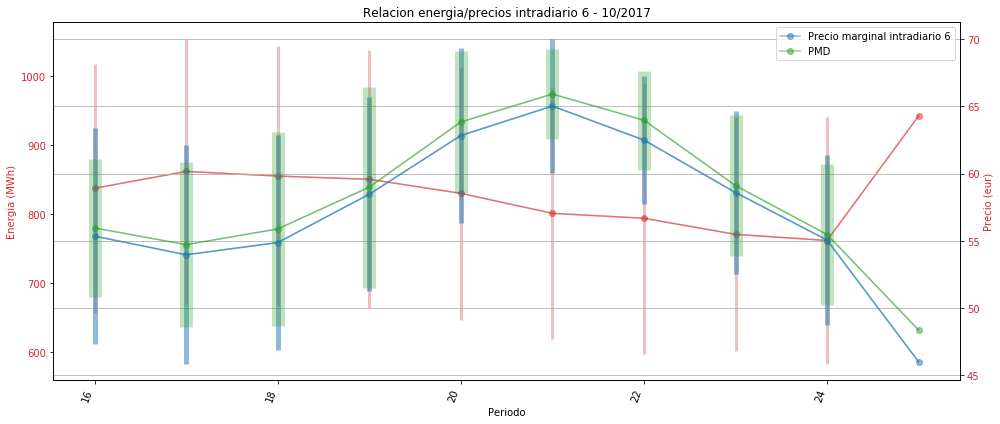

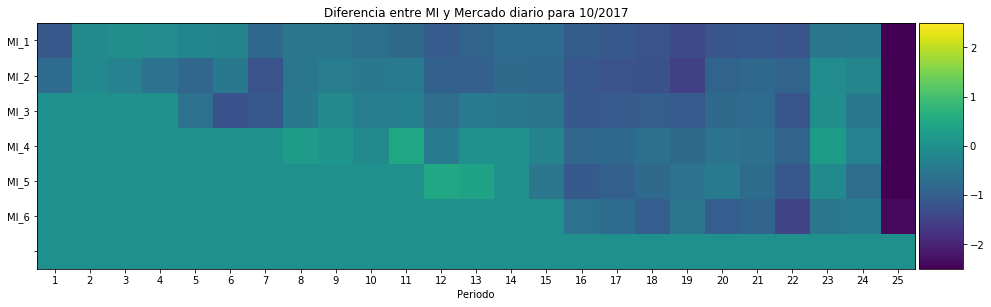

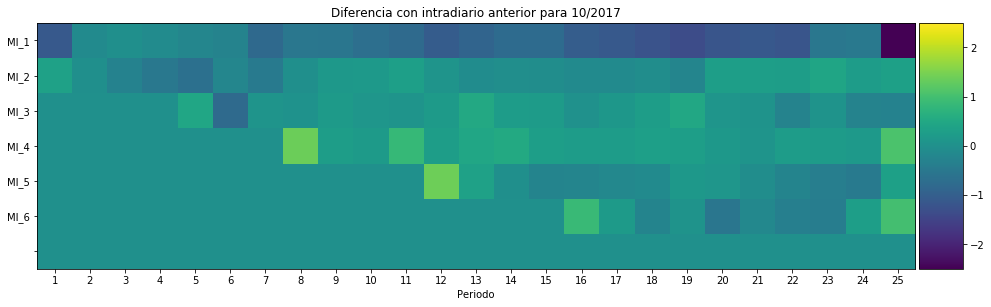

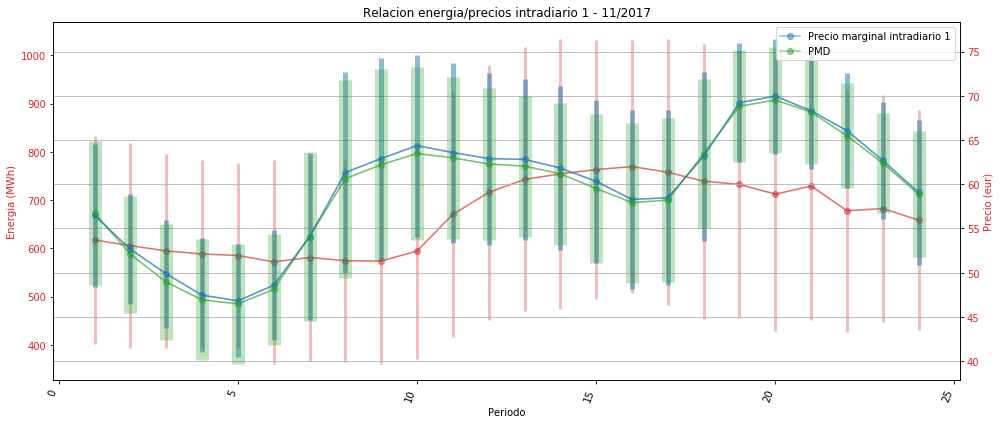

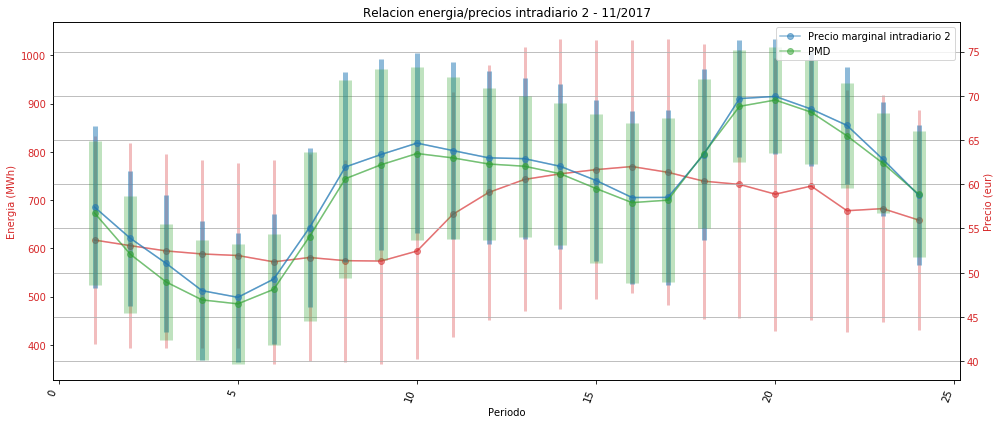

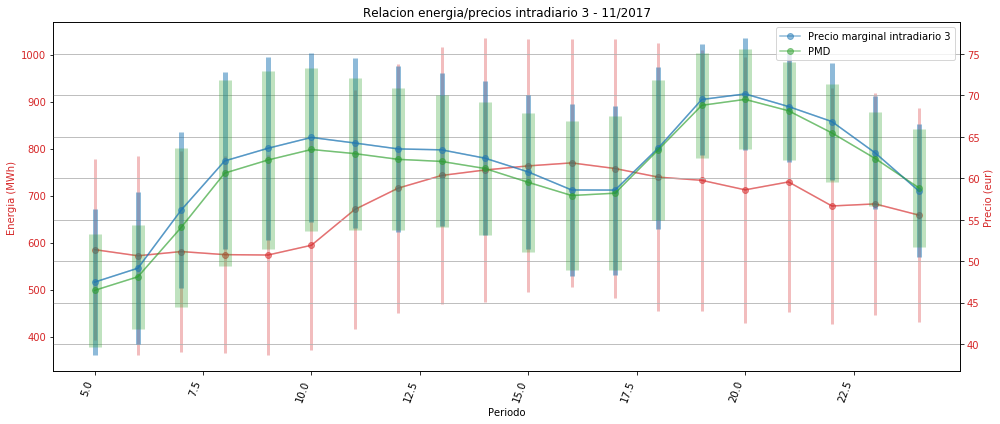

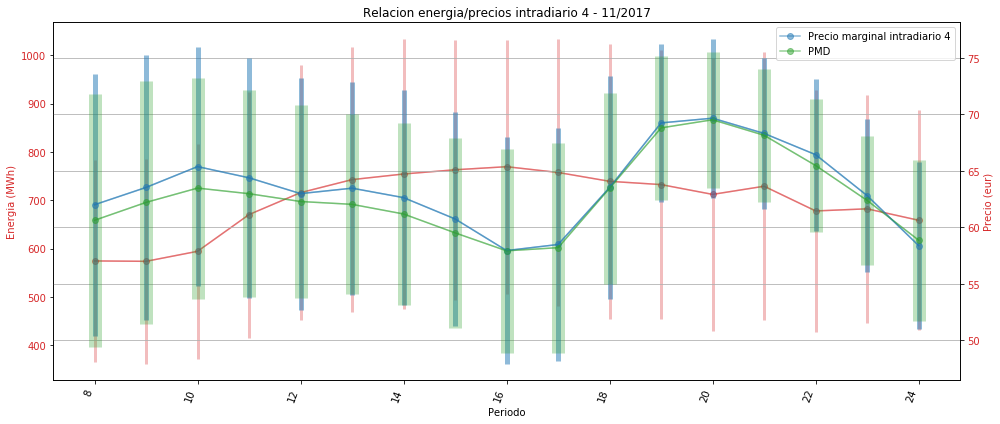

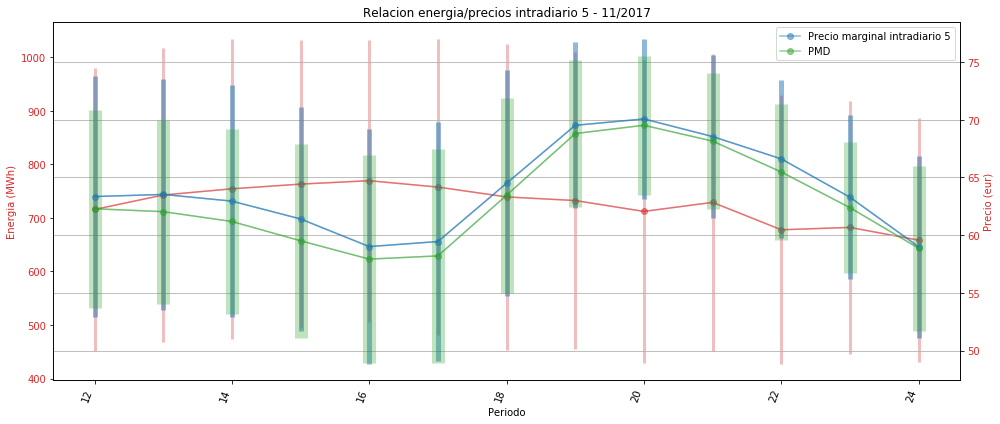

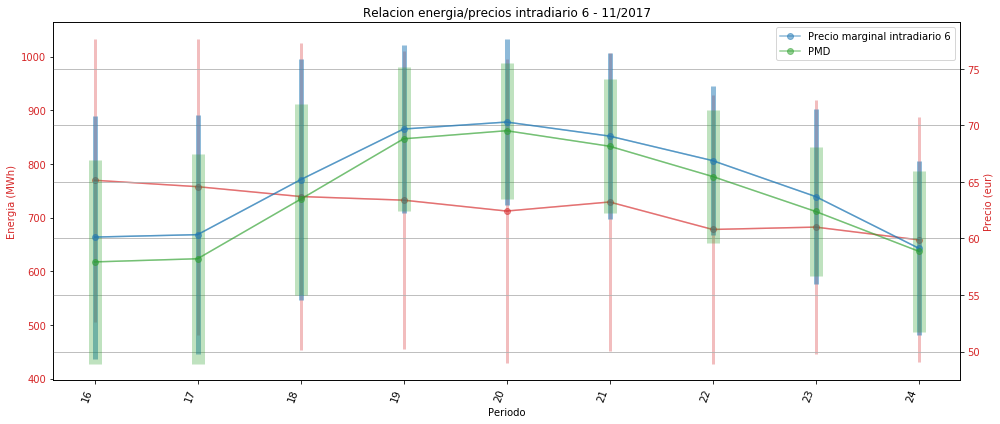

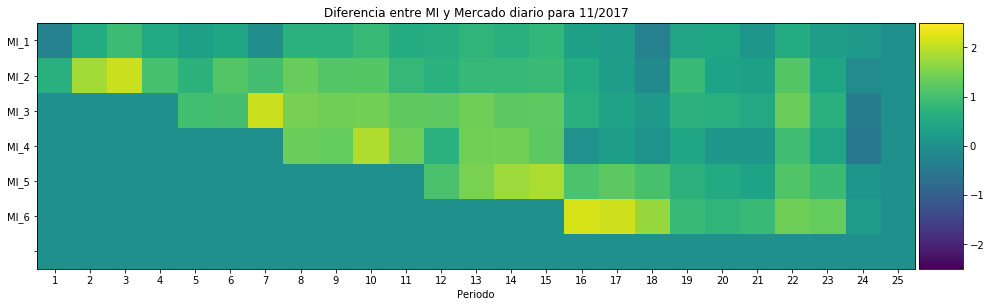

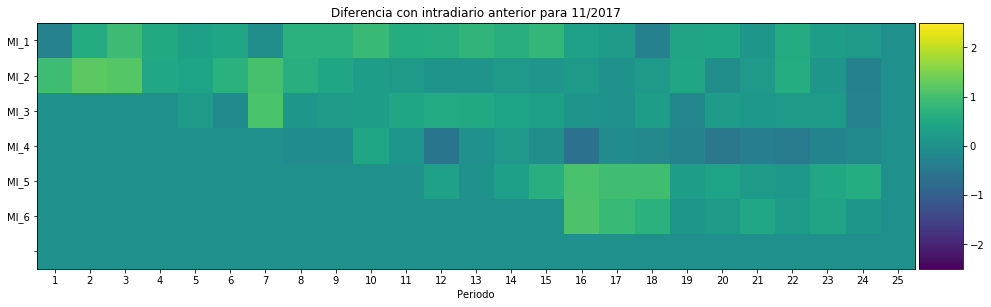

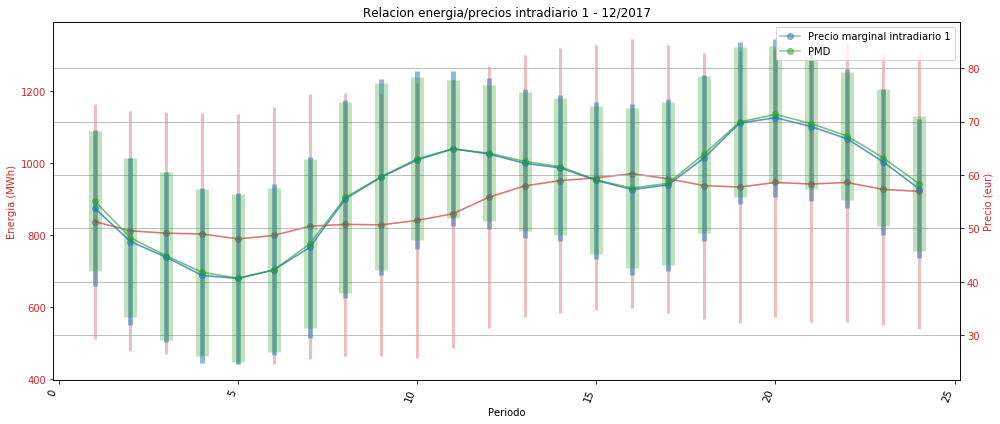

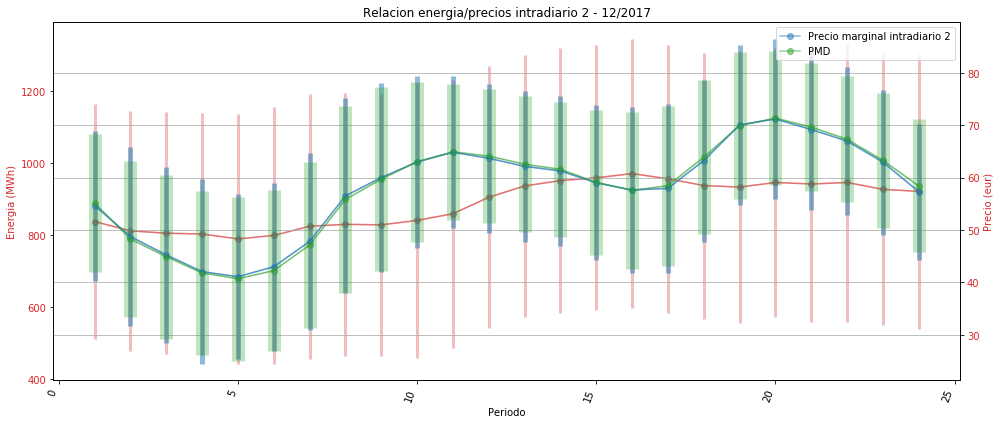

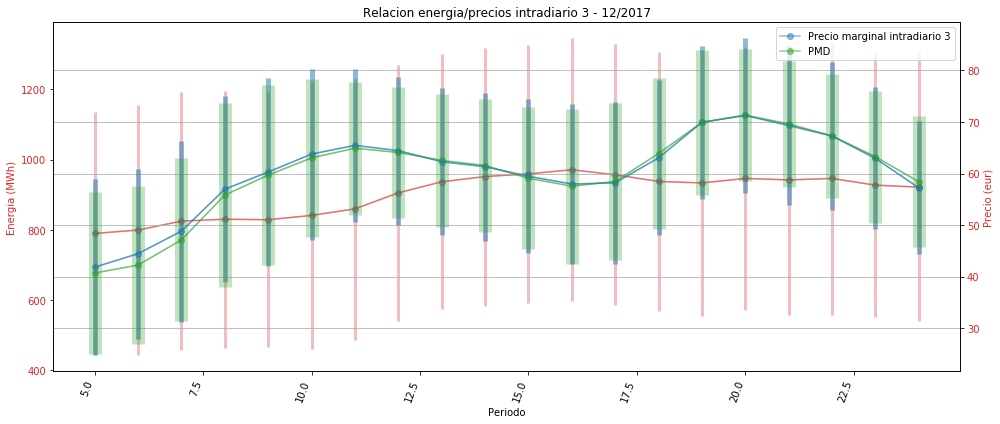

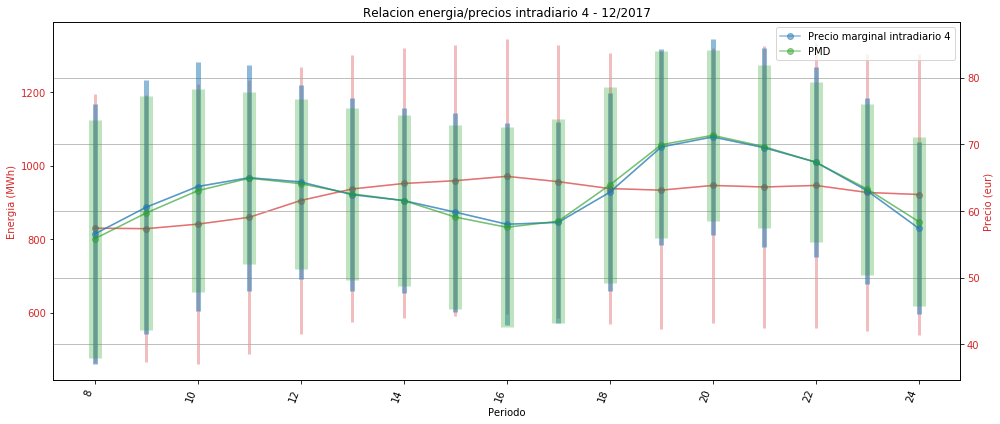

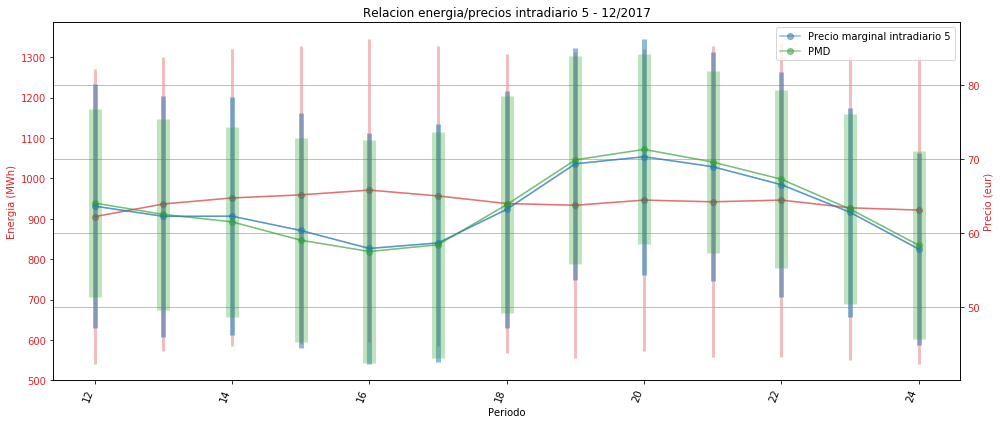

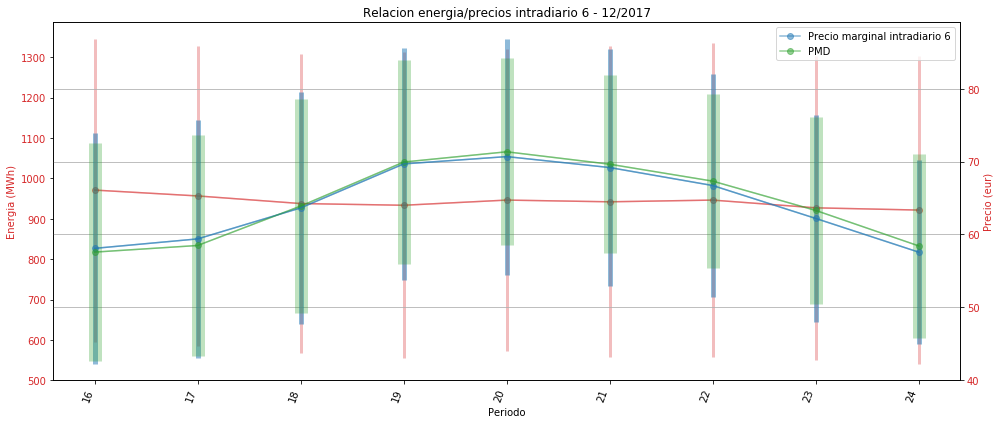

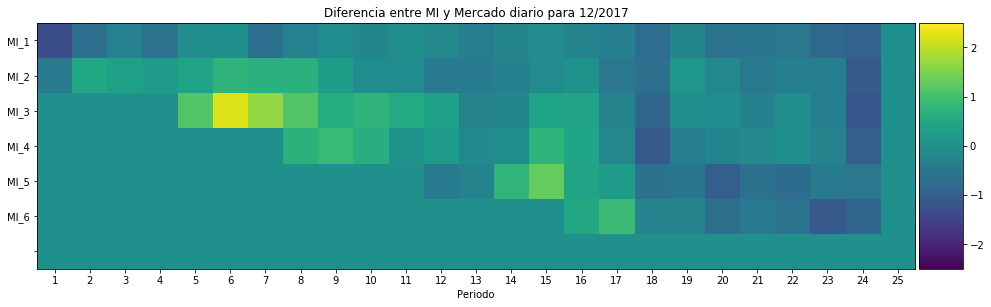

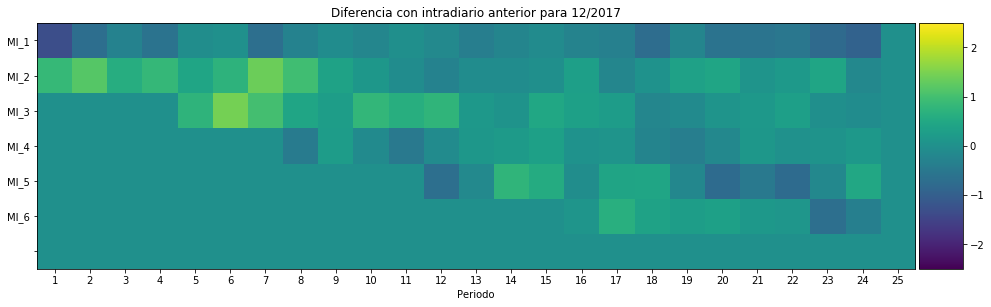

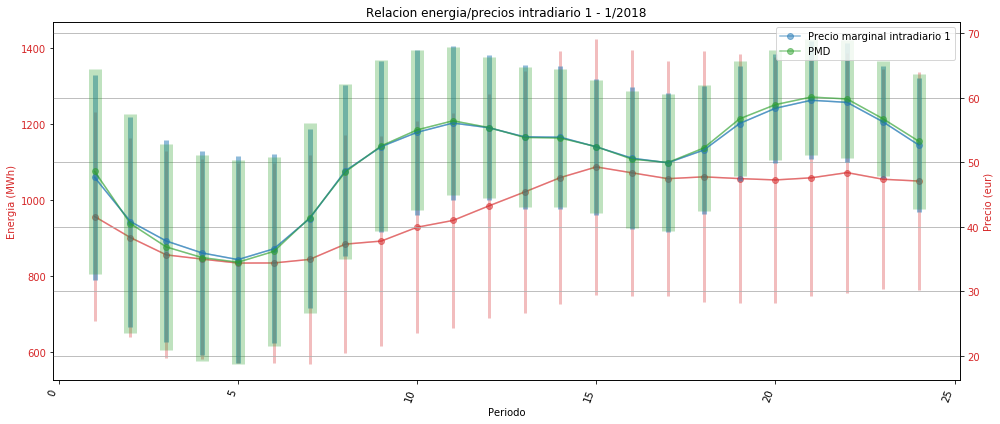

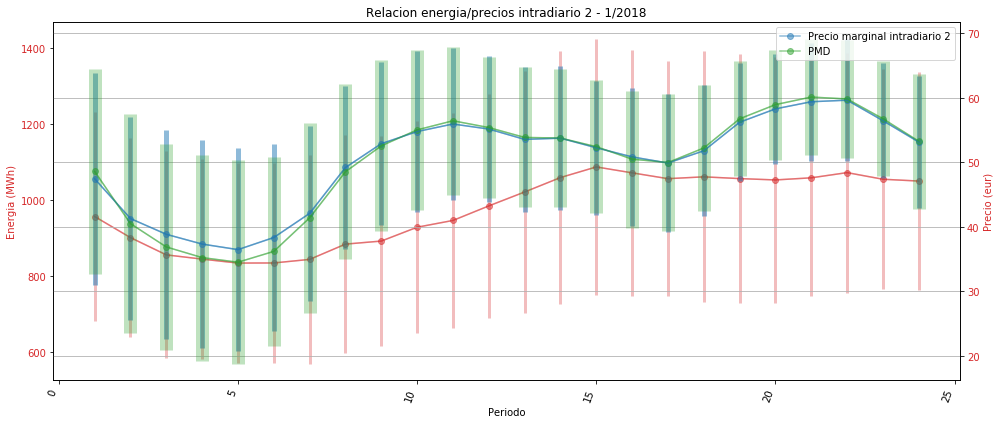

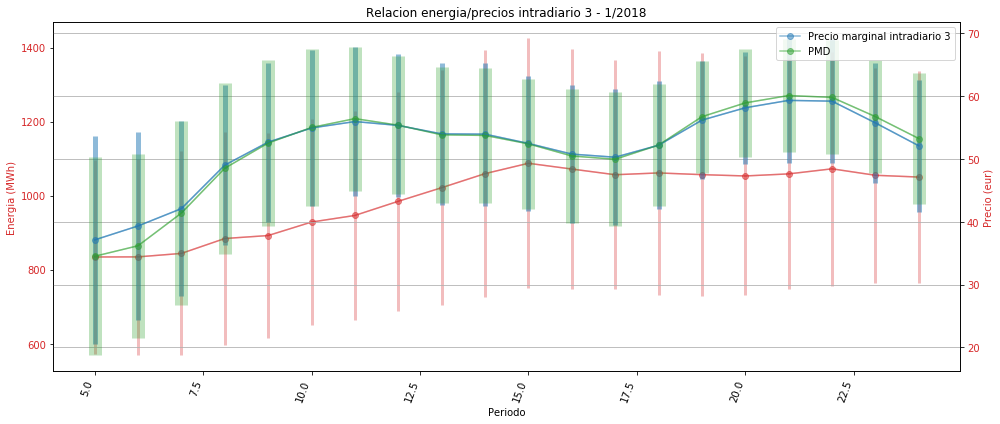

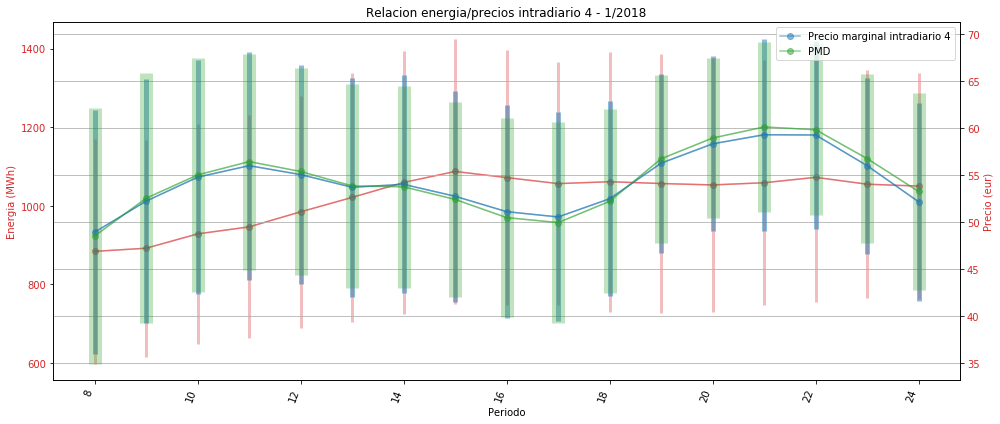

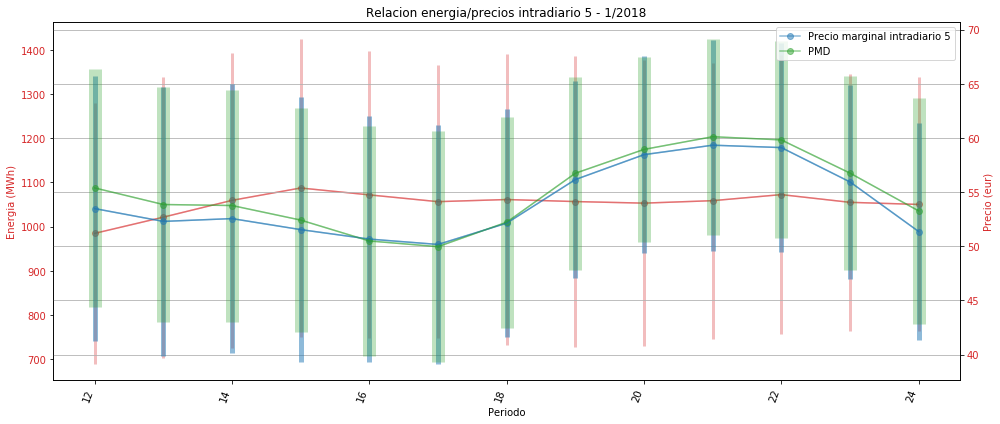

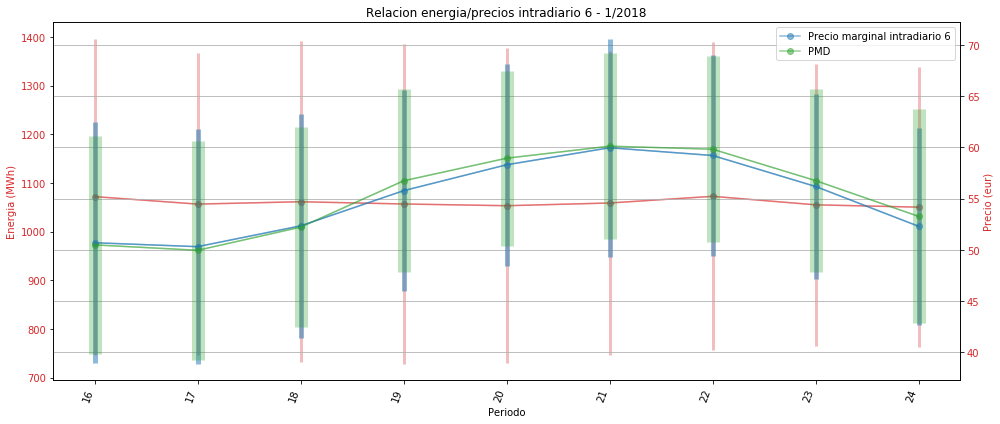

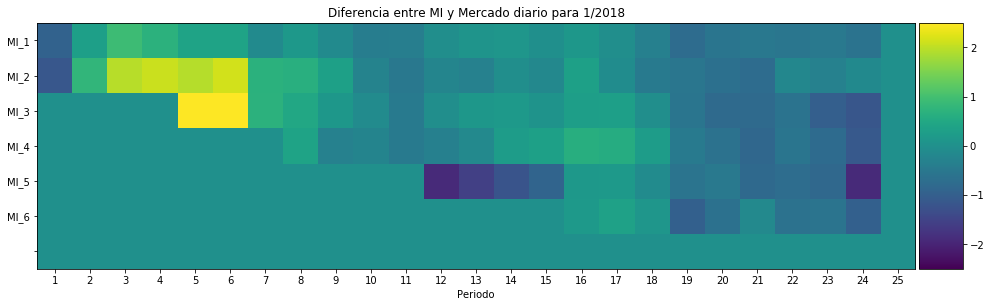

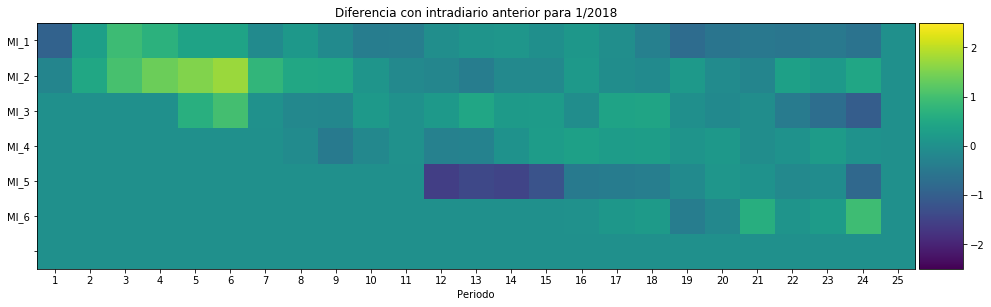

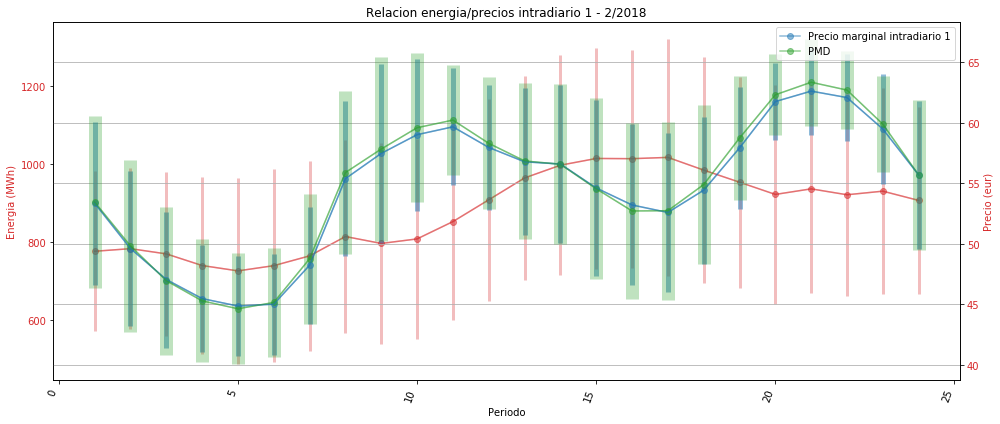

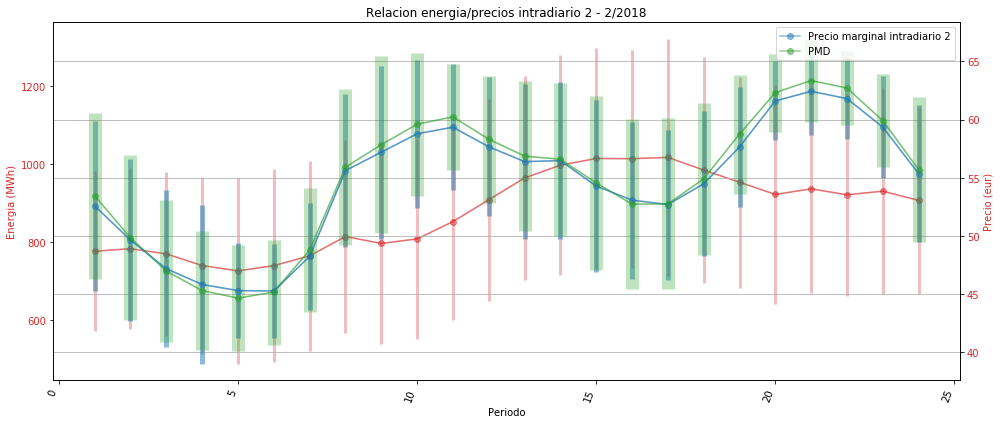

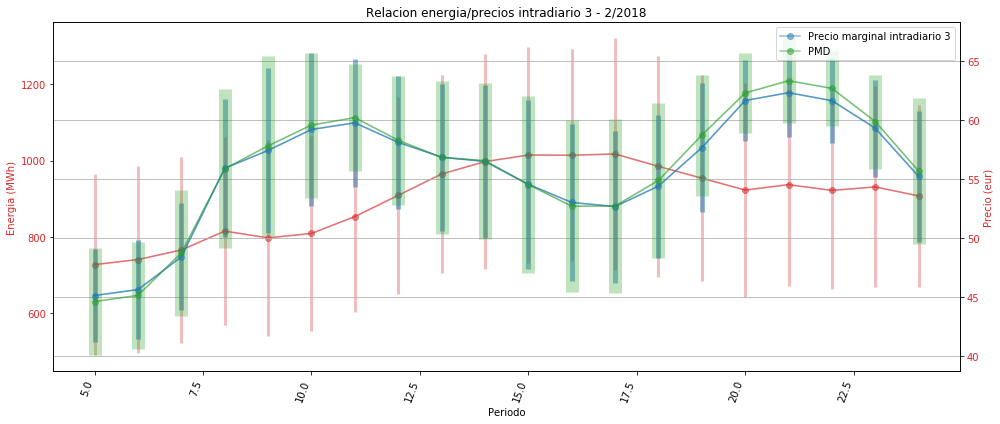

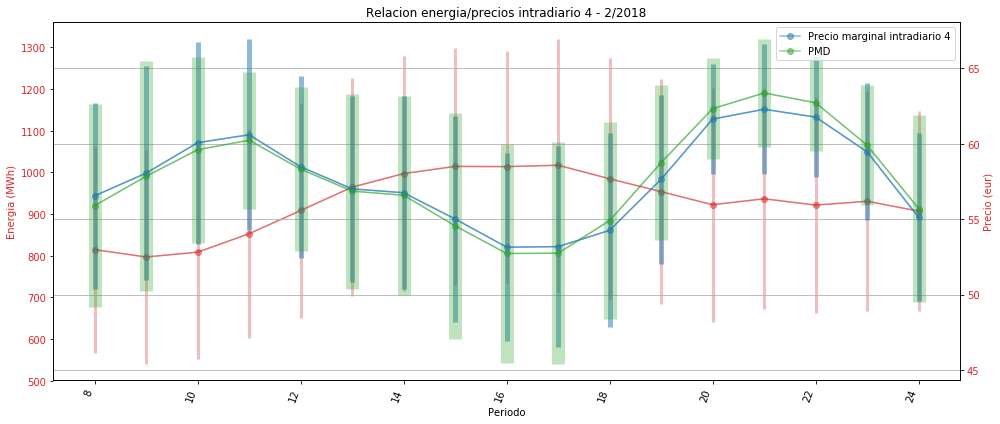

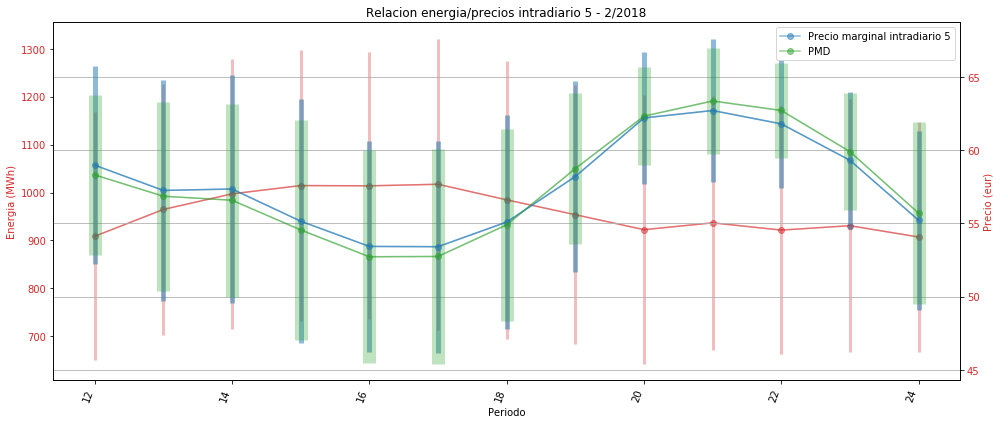

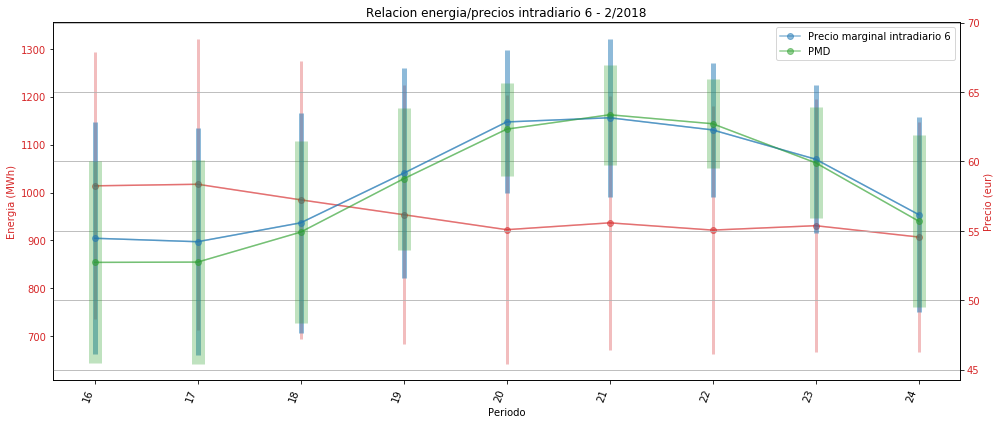

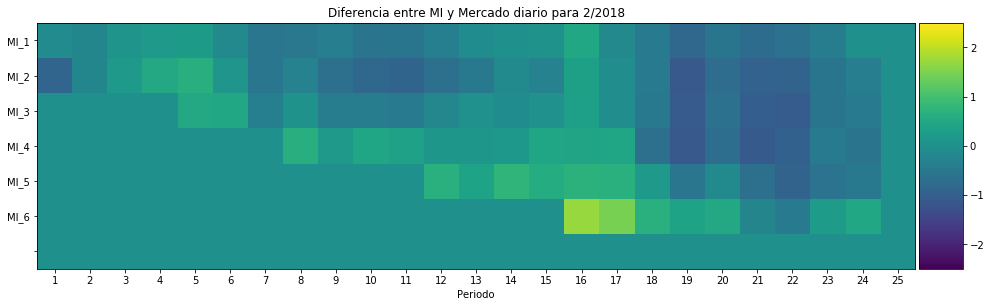

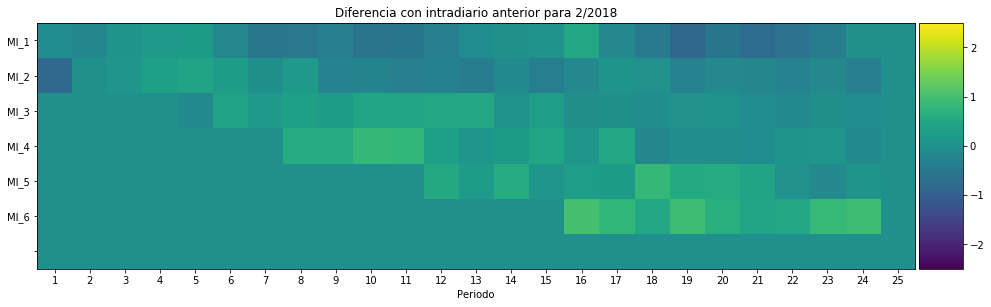

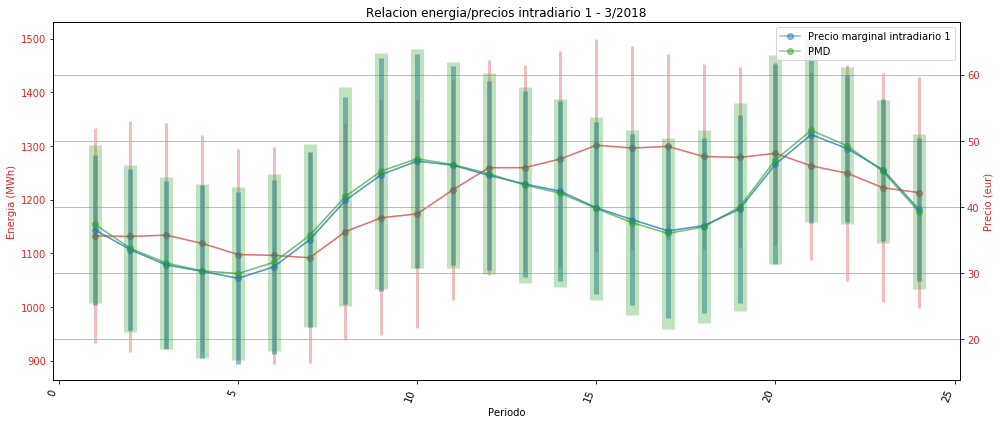

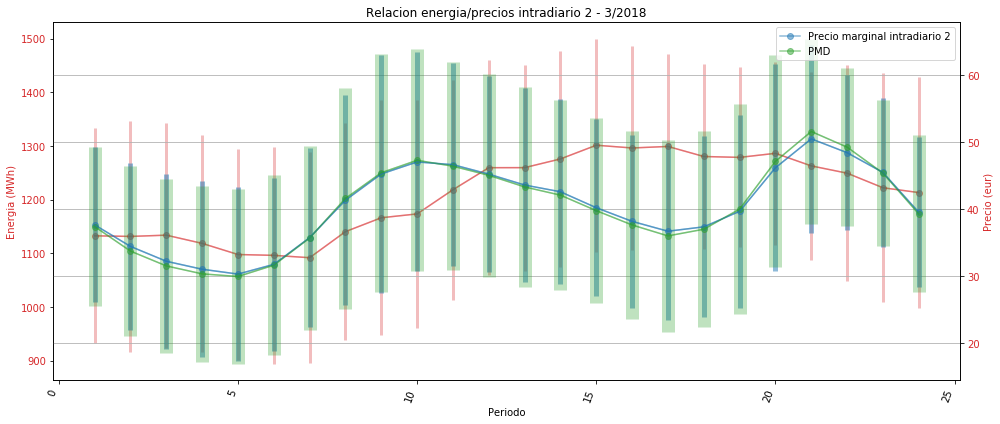

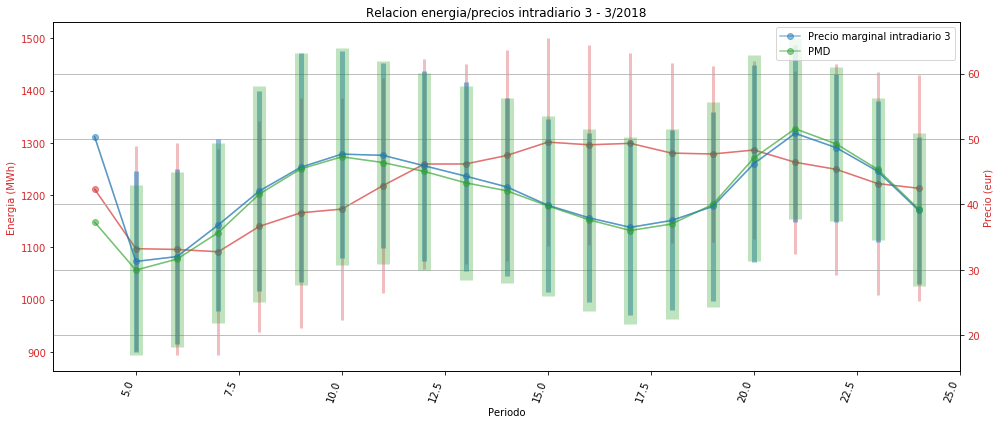

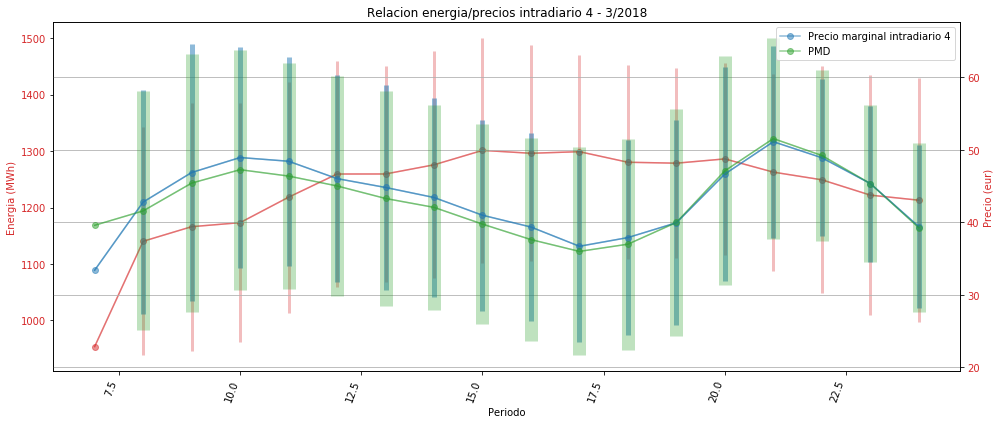

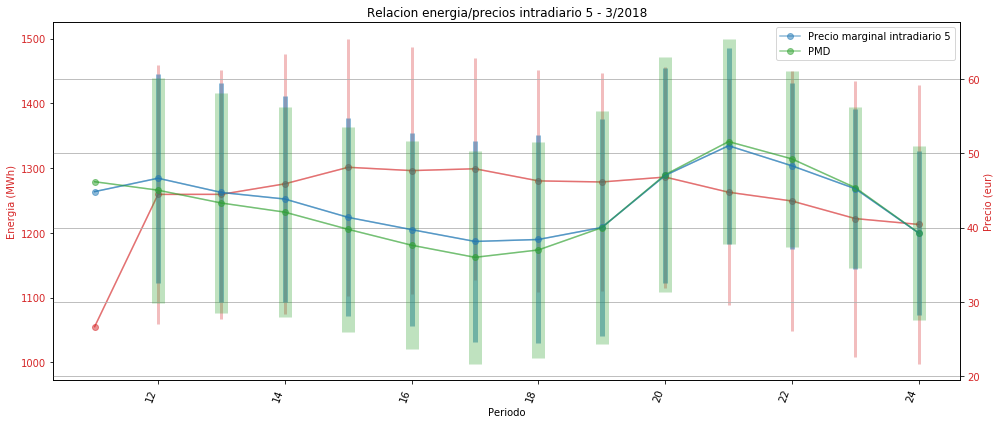

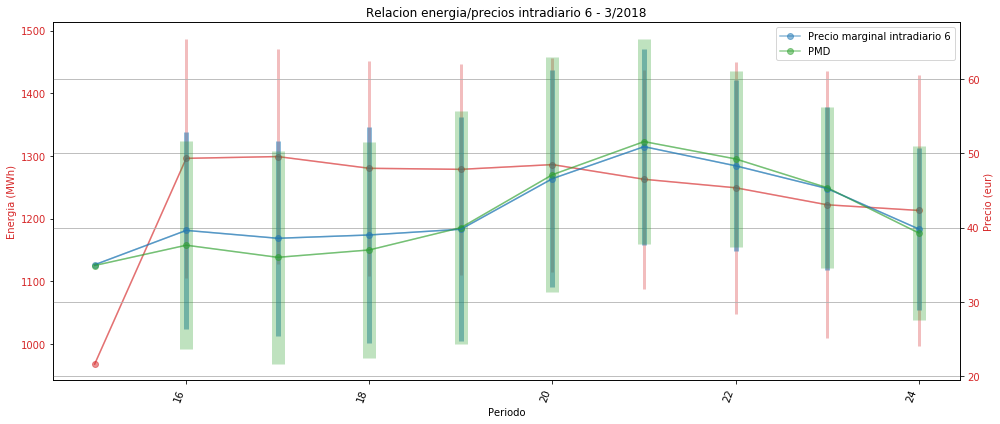

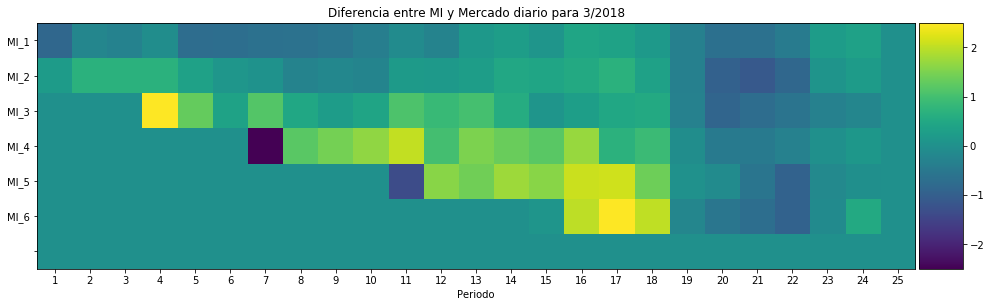

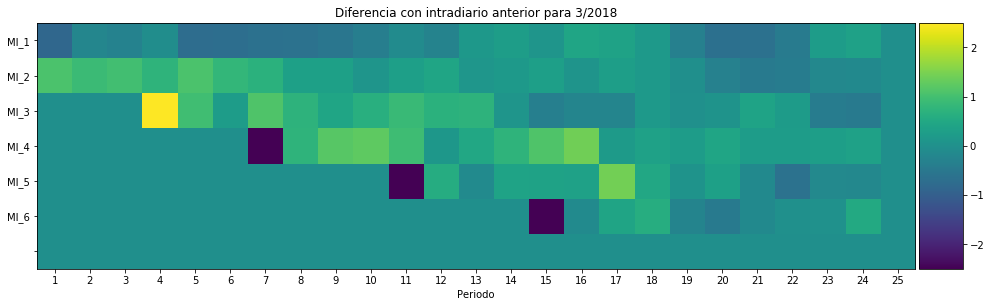

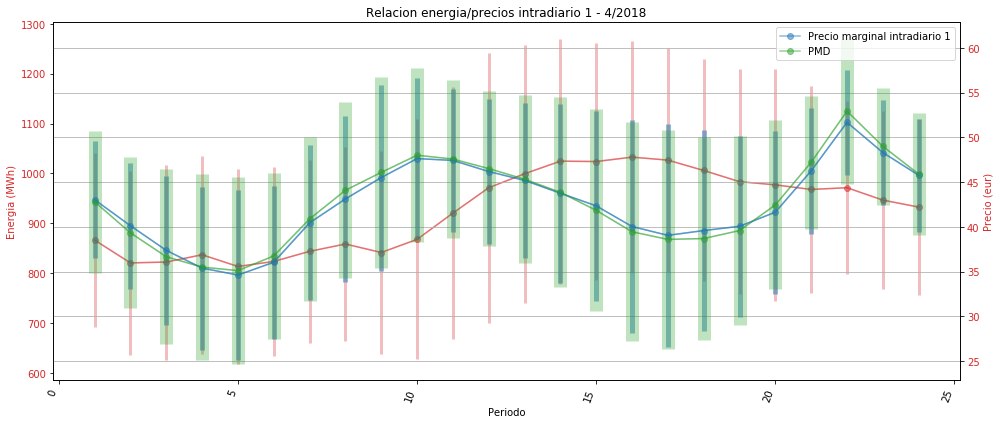

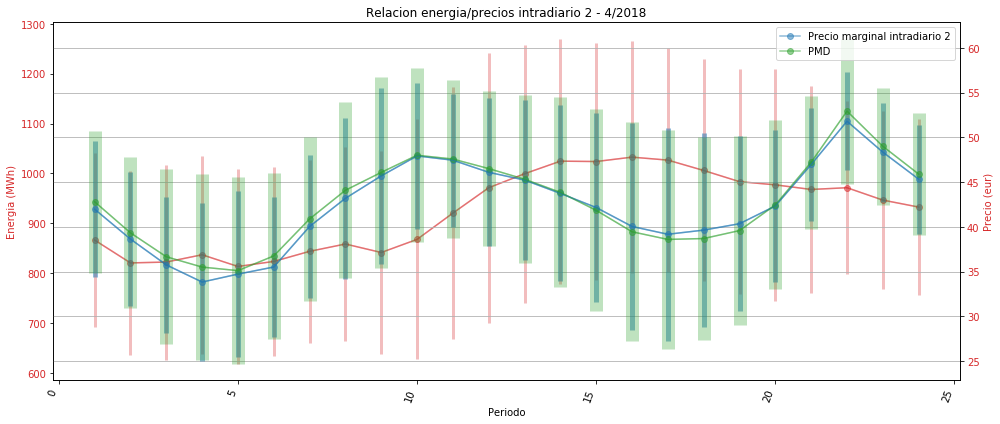

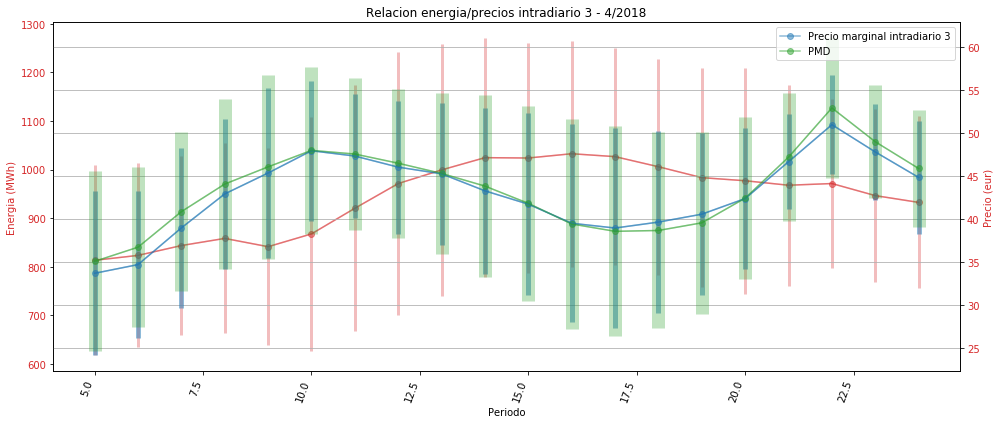

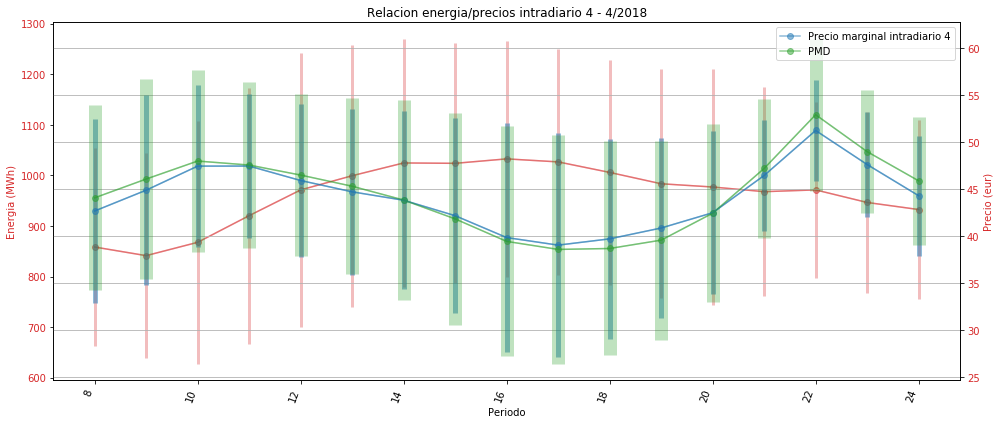

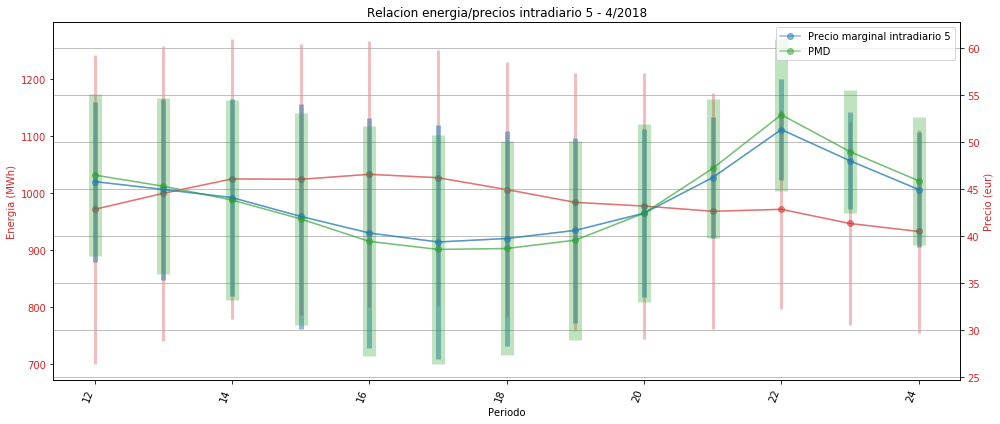

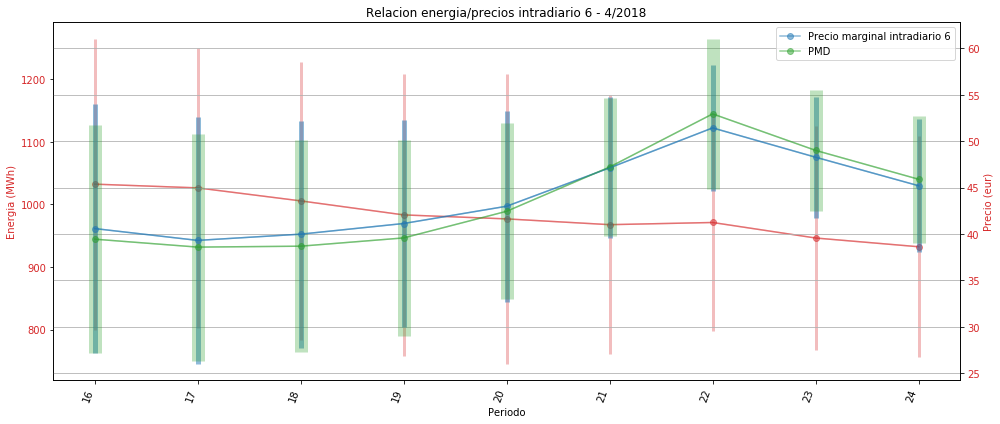

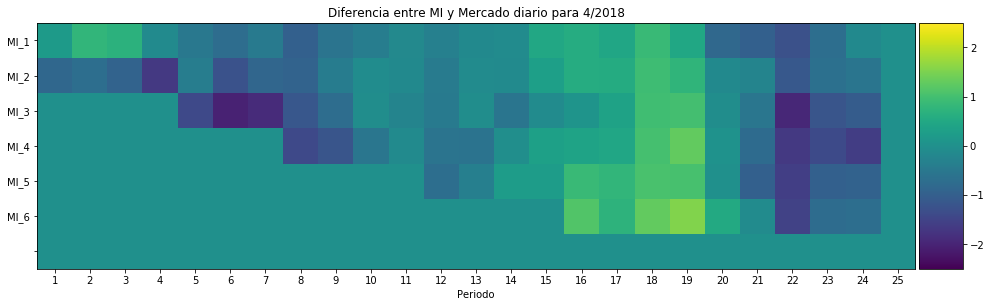

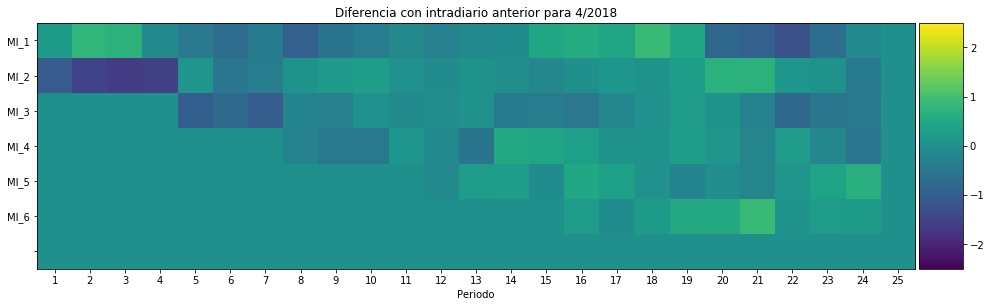

In [4]:
grouped = df.groupby(['year','mes','intraday','periodo']).agg(AGGREGATIONS).reset_index()

for year, mes in zip([2017, 2017, 2017, 2017, 2017, 2017,2017, 2017, 2018, 2018, 2018, 2018], [5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4]):
    
    sliced = grouped[(grouped['year'] == year) & (grouped['mes'] == mes)]

    for intraday in sliced.intraday.unique():
        x = sliced[sliced['intraday'] == intraday]['periodo']
        y1 = sliced[sliced['intraday'] == intraday]['energia']['mean']
        y1_std = sliced[sliced['intraday'] == intraday]['energia']['std']
        y2 = sliced[sliced['intraday'] == intraday]['marginalES']['mean']
        y2_std = sliced[sliced['intraday'] == intraday]['marginalES']['std']
        y3 = sliced[sliced['intraday'] == intraday]['pmd']['mean']
        y3_std = sliced[sliced['intraday'] == intraday]['pmd']['std']

        fig, ax1 = plt.subplots(figsize=(14,6))
        fig.autofmt_xdate(bottom=0.2, rotation=70, ha='right') # rotations of the xticks

        momento = '{0}/{1}'.format(mes, year)
        
        color = 'tab:red'
        ax1.set_title('Relacion energia/precios intradiario {0} - '.format(intraday) + momento)
        ax1.set_xlabel('Periodo')
        ax1.set_ylabel('Energia (MWh)', color=color)
        ax1.plot(x, y1, color=color, alpha=0.5, marker='o')
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        ax2.set_ylabel('Precio (eur)', color=color)  # we already handled the x-label with ax1
        ax2.plot(x, y2, color='tab:blue', alpha=0.5, marker='o', label='Precio marginal intradiario {0}'.format(intraday))
        ax2.plot(x, y3, color='tab:green', marker='o', alpha=0.5, label='PMD')
        ax2.tick_params(axis='y', labelcolor=color)    
        
        plt.legend()
        
        alpha = 0.3
        ax1.errorbar(x, y1, yerr=y1_std, color='tab:red',  elinewidth=3, alpha=alpha)
        ax2.errorbar(x, y2, yerr=y2_std, color='tab:blue',  elinewidth=5, alpha=alpha+0.2)
        ax2.errorbar(x, y3, yerr=y3_std, color='tab:green', elinewidth=13, alpha=alpha)
        
        
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.axis('tight')
        plt.grid()
        plt.show();       

    ut.plot_heatmap(ut.get_prices_diff_intraday_vs_pmd(sliced), 'Diferencia entre MI y Mercado diario para '+ momento)
    ut.plot_heatmap(ut.get_prices_diff_intraday_vs_previous_intraday(sliced), 'Diferencia con intradiario anterior para '+ momento)

    print('='*119)

### Segun lo observado:
#### Algunas conclusiones:
 - Salvo casos puntuales, como lo es el 11/2017, la curva de PMD se mantiene por encima del precio del mercado para todos los intradiarios.
 - En el mes 12/2017 se observa la mayor amplitud de precio, que va desde 40 a 72 aprox.
 - En el intradiario 3 del mes 3/2018 hay un caso extraño de diferencia de precios.
 - Siempre que la energia generada por w2m aumenta, el precio disminuye, tanto el PMD como el precio intradiario. Esto tiene sentido ya que esta energia es de tipo renovable. Por ejemplo, en el mes 9/2017, para el periodo 14, hay un aumento de 1000 en la media de la energia generada y un decremento de aprox €2 en los precios casados; dicho esto, puede 1000 MWh MWh/30d (30 MWh extra por dia para un periodo) ser representativo para explicar una caida en la media mensual tanto del PMD como del MI1 de ~ €2? Otros ejemplos de esto son: intradiario 1 de 05/2017. En el intradiario 1 de 08/2017 esto no se cumple entre los periodos 9 y 15
 - Exceptuando las anomalias que se presentan en los intradiarios 3 y 5 del mes 3/2018, los valores de las diferencias entre las medias de los precios van desde [€3, €-2]. A partir de que valor es representativa una diferencia en los precios?


## Agrupacion por año - intradiario - periodo 

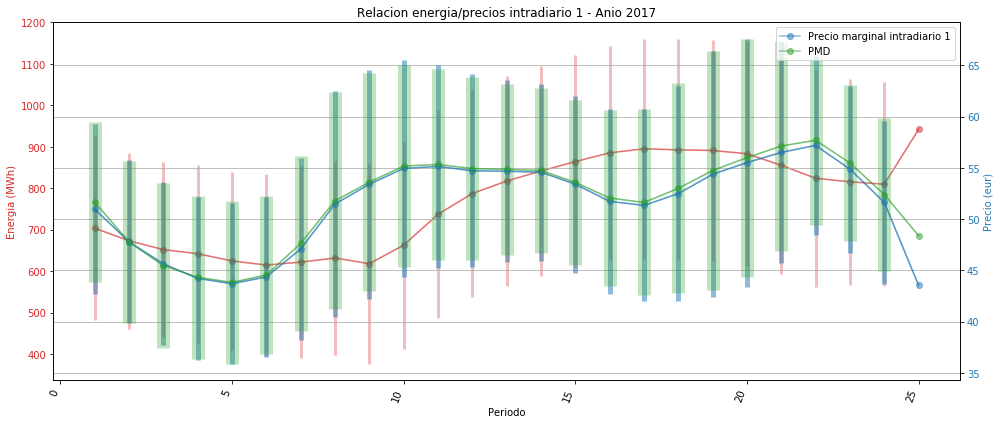

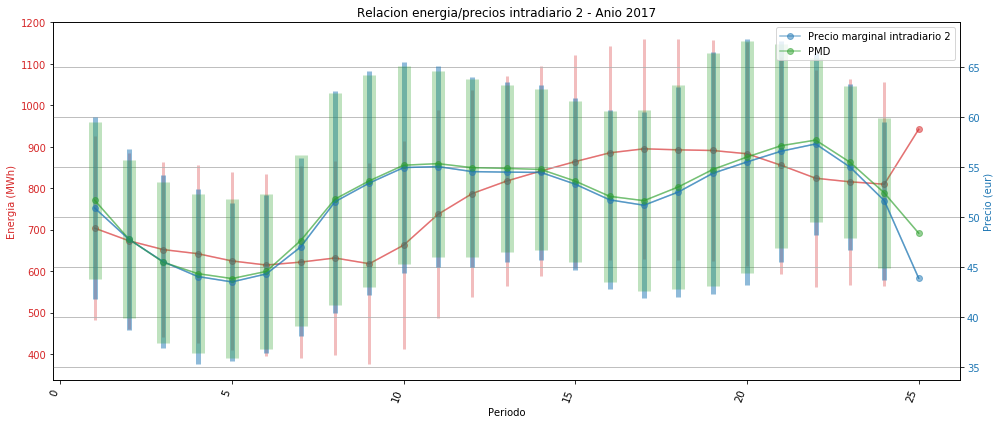

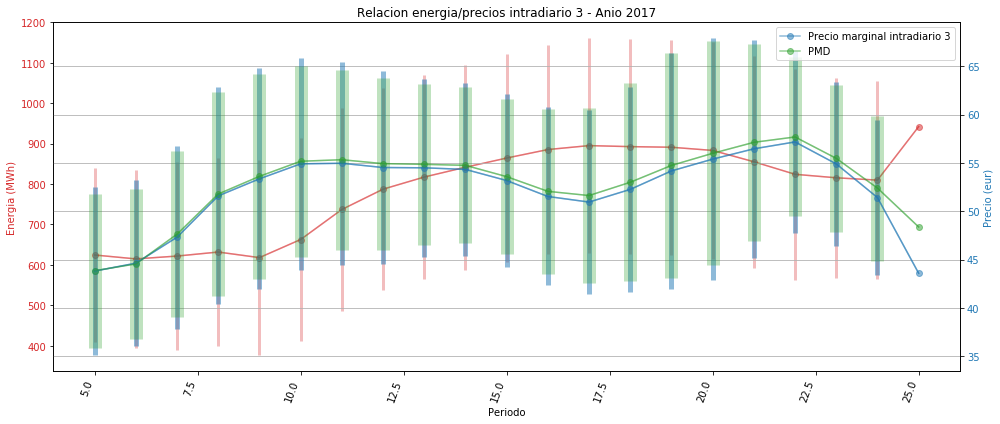

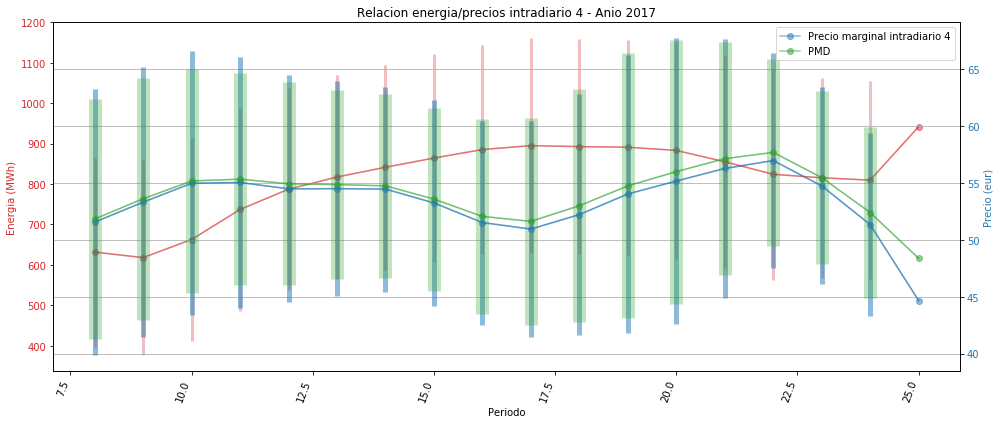

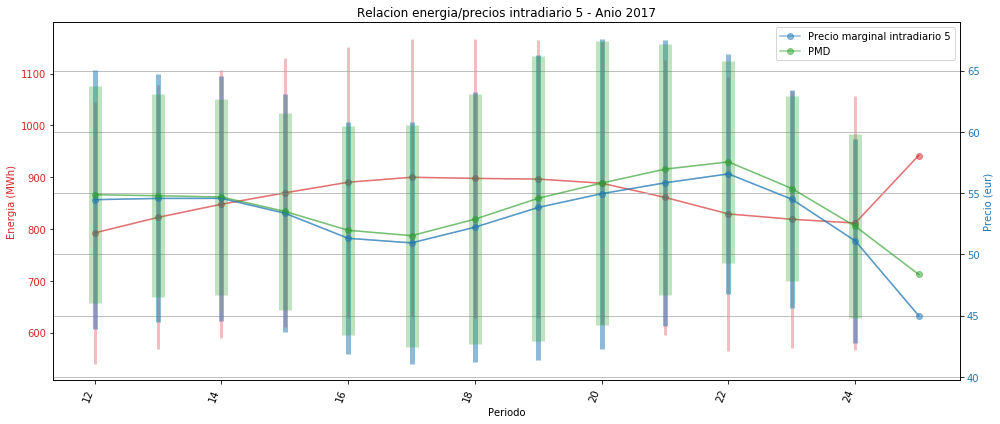

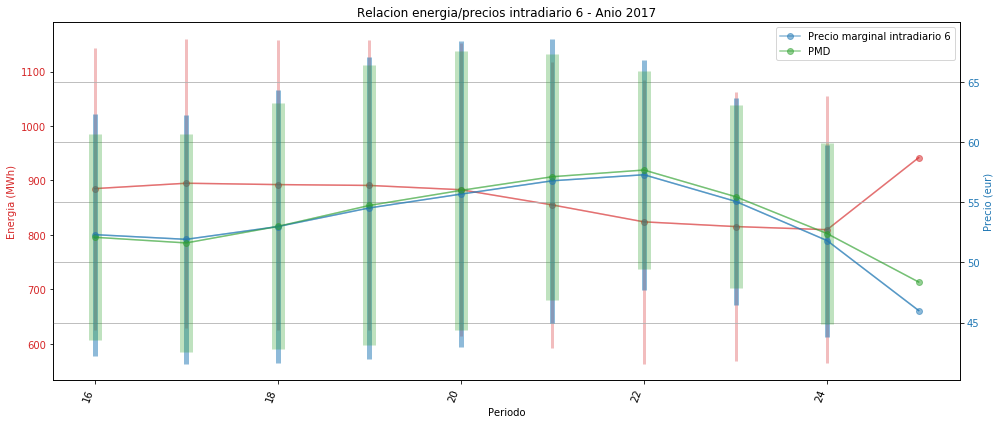

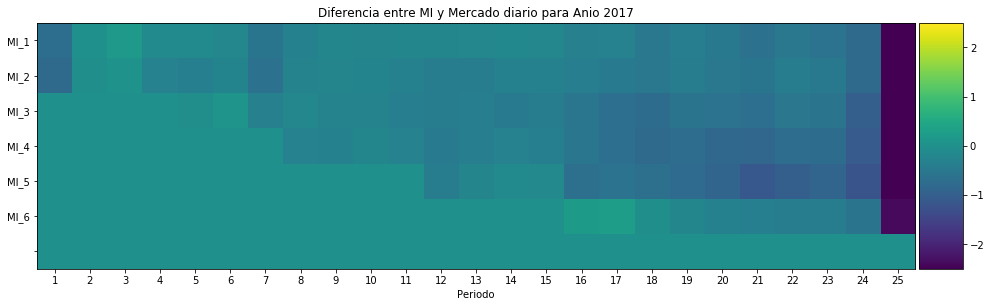

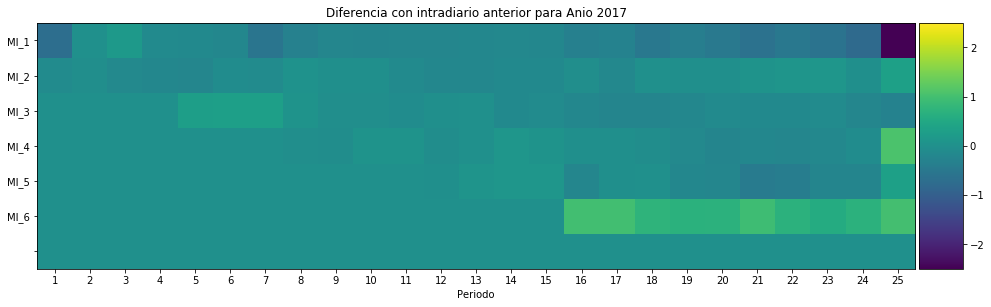

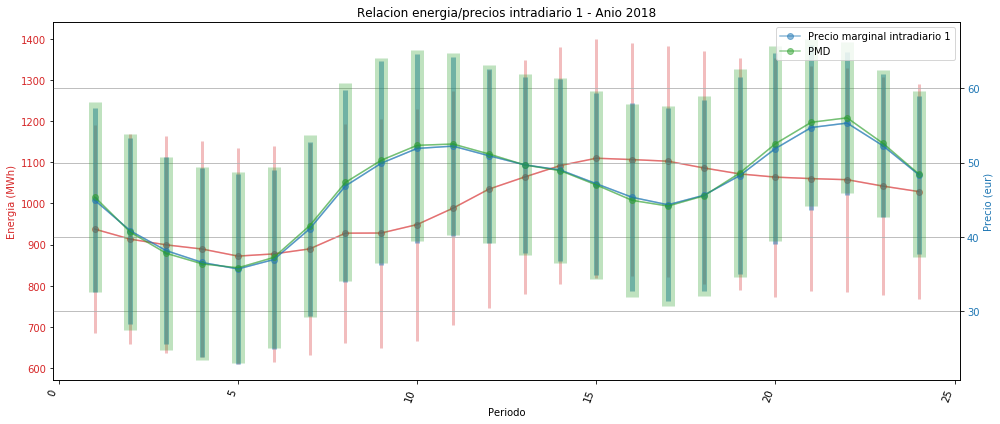

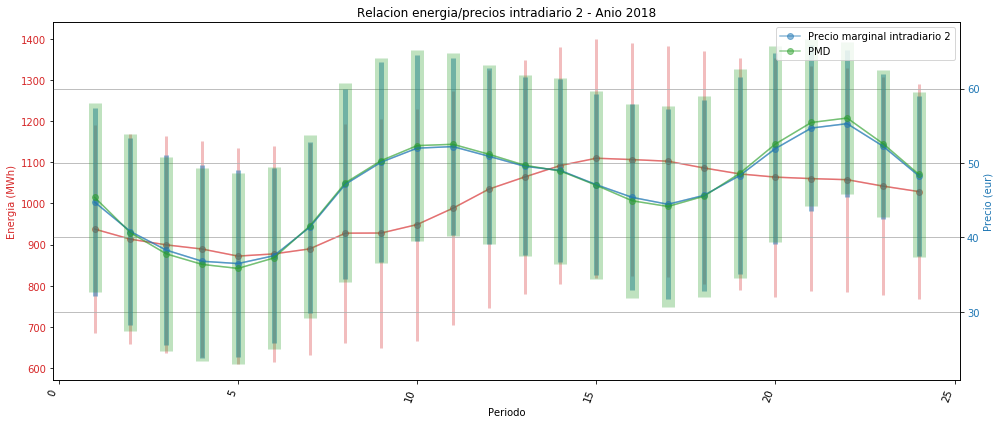

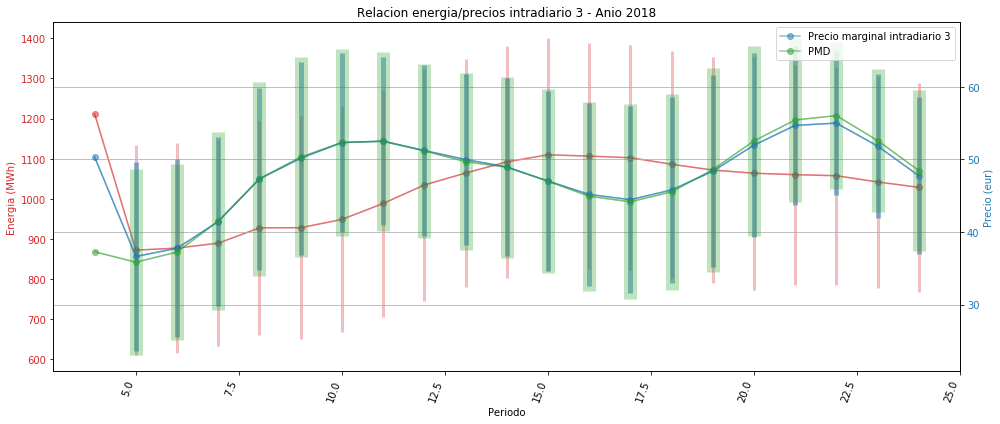

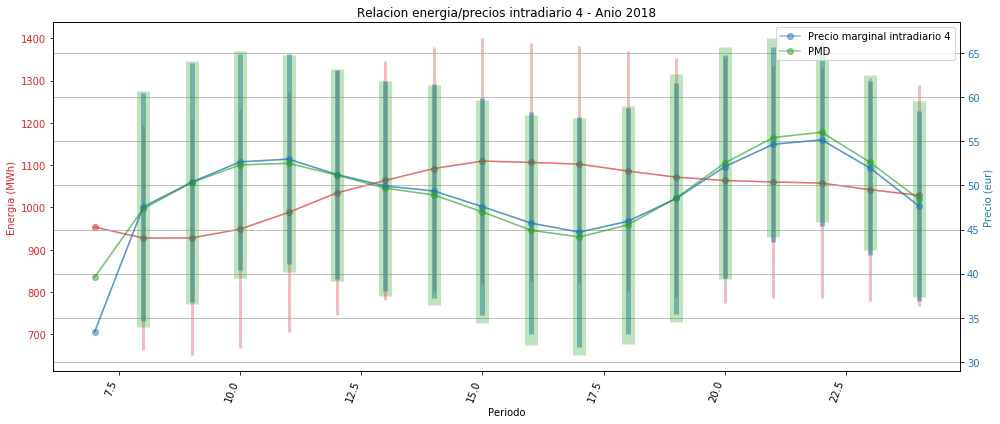

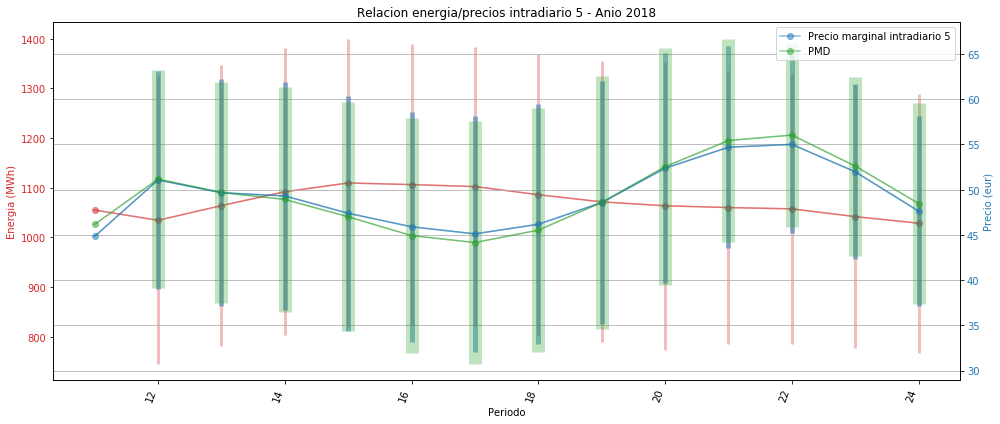

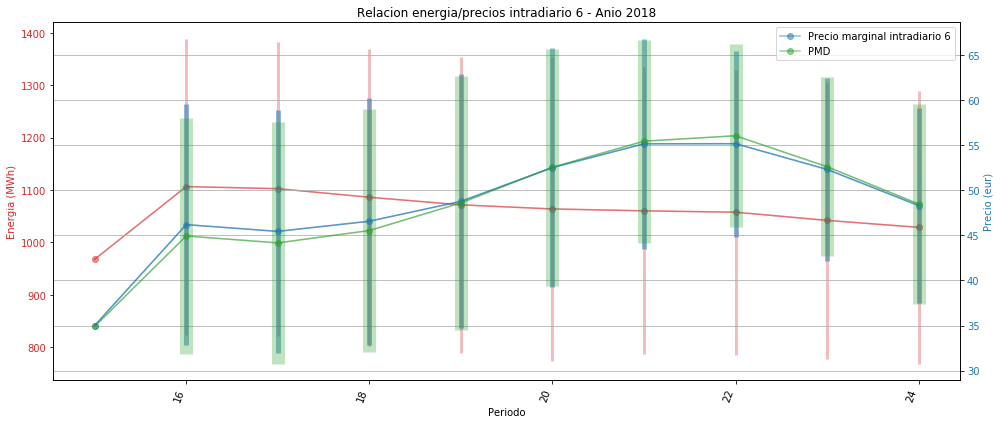

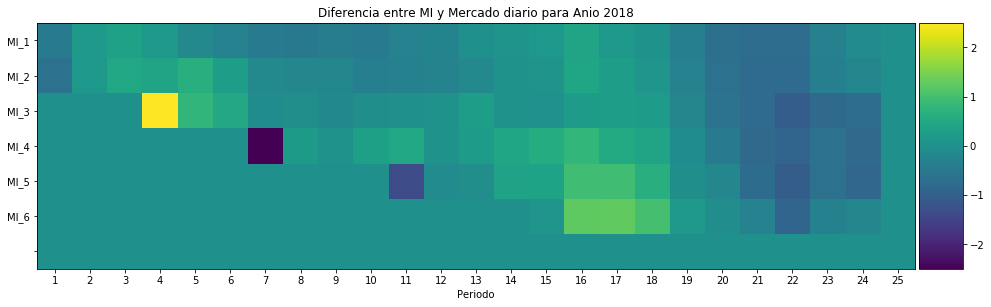

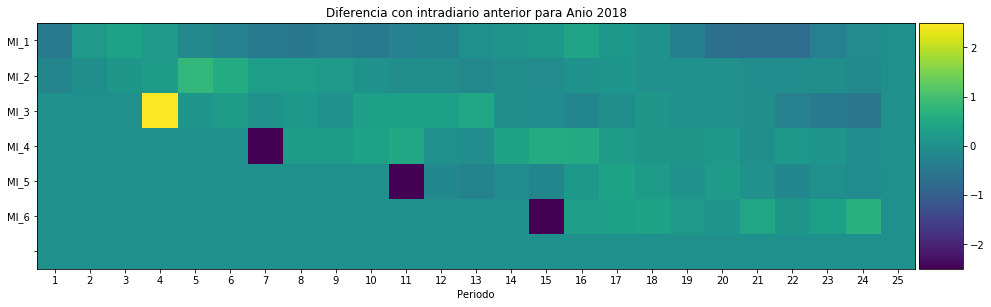

In [5]:
grouped = df.groupby(['year','intraday','periodo']).agg(AGGREGATIONS).reset_index()

for year in [2017,2018]:
    sliced = grouped[(grouped['year'] == year)]

    for intraday in sliced.intraday.unique():
        x = sliced[sliced['intraday'] == intraday]['periodo']
        y1 = sliced[sliced['intraday'] == intraday]['energia']['mean']
        y1_std = sliced[sliced['intraday'] == intraday]['energia']['std']
        y2 = sliced[sliced['intraday'] == intraday]['marginalES']['mean']
        y2_std = sliced[sliced['intraday'] == intraday]['marginalES']['std']
        y3 = sliced[sliced['intraday'] == intraday]['pmd']['mean']
        y3_std = sliced[sliced['intraday'] == intraday]['pmd']['std']

        fig, ax1 = plt.subplots(figsize=(14,6))
        fig.autofmt_xdate(bottom=0.2, rotation=70, ha='right') # rotations of the xticks

        momento = 'Anio {0}'.format(year)
        color = 'tab:red'
        ax1.set_title('Relacion energia/precios intradiario {0} - '.format(intraday) + momento)
        ax1.set_xlabel('Periodo')
        ax1.set_ylabel('Energia (MWh)', color=color)
        ax1.plot(x, y1, color=color, alpha=0.5, marker='o')
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Precio (eur)', color=color)  # we already handled the x-label with ax1
        ax2.plot(x, y2, color=color, alpha=0.5, marker='o', label='Precio marginal intradiario {0}'.format(intraday))
        ax2.plot(x, y3, color='tab:green', marker='o', alpha=0.5, label='PMD')
        ax2.tick_params(axis='y', labelcolor=color)    

        plt.legend()
        
        alpha = 0.3
        ax1.errorbar(x, y1, yerr=y1_std, color='tab:red',  elinewidth=3, alpha=alpha)
        ax2.errorbar(x, y2, yerr=y2_std, color='tab:blue',  elinewidth=5, alpha=alpha+0.2)
        ax2.errorbar(x, y3, yerr=y3_std, color='tab:green', elinewidth=13, alpha=alpha)
        
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.axis('tight')
        plt.grid()
        plt.show();
        
    ut.plot_heatmap(ut.get_prices_diff_intraday_vs_pmd(sliced), 'Diferencia entre MI y Mercado diario para '+ momento)
    ut.plot_heatmap(ut.get_prices_diff_intraday_vs_previous_intraday(sliced), 'Diferencia con intradiario anterior para '+ momento)

    print('='*120)

### Segun lo observado:

Vale aclarar que aunque las agrupaciones sean anuales, para el 2017 se encuentran comprendidos solo los meses del 5-12 y para el 2018 del 1-4 inclusive.

#### Algunas conclusiones:
 - En los intradiarios 3, 4, 5 y 6 de 2018 la curva de precio de MI esta por encima de la de PMD
 - Aunque con menor pendiente (tanto positiva como negativa), los comportamientos descriptos para las agrupaciones mensuales se mantienen.

### Correlacion de variables

In [6]:
df = df.reset_index()
cols = ['marginalES','pmd','desvio_sistema','demanda_real','hueco_termico','hidraulica_eolica','diff_pmd_marginalES','energias_sin_comb_fosil','generación_t_real_carbón']
corr = df[cols].corr()
corr.style.background_gradient().set_precision(2)

#### Se observa que:
 - Existe alta correlacion entre el hueco termico y la generacion de carbon, a su vez, correlacion negativa entre el hueco termico y la generacion hidraulica/eolica (y en menor medida con la suma de las energias sin combustible fosil). Lo que tiene sentido, ya que '"*El hueco térmico está formado por toda la generación térmica de combustible fósil, que son centrales de carbón y de gas. Se obtiene restando a la demanda todas las variables de generación que no usen combustible fósil, incluyendo nuclear.*"' 
 - Tanto el pmd como el precio intradiario (marginalES) tienen ~0.5 de correlacion con la demanda y el hueco termico, esto se explica porque, para el primer caso, al aumentar la demanda, la casacion se da en un precio mas alto; mientras que para el segundo caso tiene sentido decir que cuando cambia el hueco termico, de su mano cambiaran los precios.
 - Lo que no se esperaba era la correlacion entre la demanda y las energias sin combustible fosil, dado que estas variables entendemos que son independientes entre si.

### Algunos estadisticos referidos a los desvios de los precios y sus diferencias

 - **pmd**: Desvio estandar para PMD
 - **marginalES**: desvio estandar de los precios intradiarios
 - **diff_pmd_marginalES**: desvio estandar para la diferencia entre pmd e intradiarios
 - **diff_std_pmd_marginalES**: diferencia entre los desvios estandar de PMD (pmd) y precios intradiarios (marginalES)

In [7]:
df_std = df.groupby(['intraday']).agg({'pmd':'std', 'marginalES':'std', 'diff_pmd_marginalES':'std'}).reset_index()
df_std['diff_std_pmd_marginalES'] = df_std['marginalES'] - df_std['pmd']
df_std

intraday        pmd  marginalES  diff_pmd_marginalES  \
0         1  11.600374   11.612036             2.175217   
1         2  11.600374   11.686331             3.148500   
2         3  11.442940   11.656422             3.340346   
3         4  10.959091   11.311930             3.503012   
4         5  10.803377   11.368533             4.019205   
5         6  11.110655   11.714956             4.613746   

   diff_std_pmd_marginalES  
0                 0.011662  
1                 0.085957  
2                 0.213483  
3                 0.352839  
4                 0.565156  
5                 0.604302

### Describiendo lo sucedido en una fecha con segun los datos de la web de ree/omie

 - [ https://demanda.ree.es/visiona/peninsula/demanda/total/2018-08-25 ]
 - [ http://www.omie.es/files/flash/ResultadosMercado.swf ]

#### Se setea el periodo en 0-23 para poder usarlo como timeseries de pandas

In [8]:
df['periodo'] = df['periodo'] - 1
df = df[df.periodo <= 23]

format = '%Y-%m-%d %H:%M:%S'
df['datetime'] = pd.to_datetime(df['fecha'].astype(str) + ' ' + df['periodo'].astype(str) + ':00:00', format=format)

# Relacion precio diario vs precio intradiario 1 por dia del mes

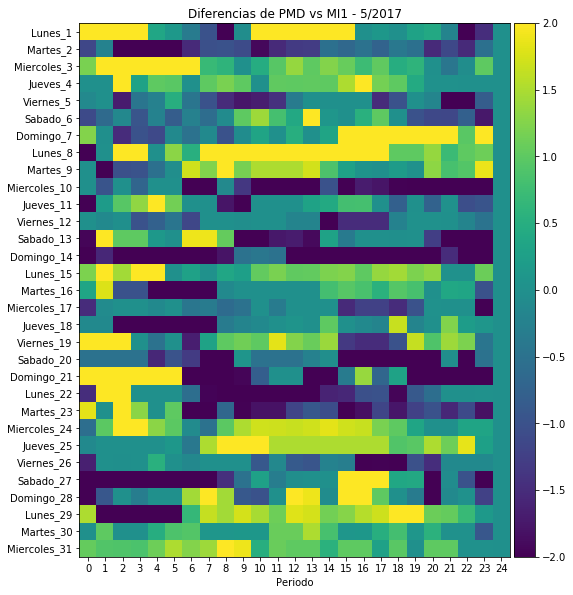

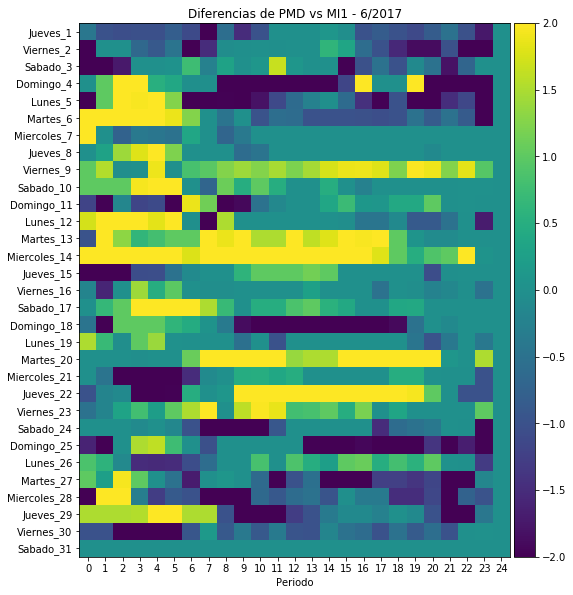

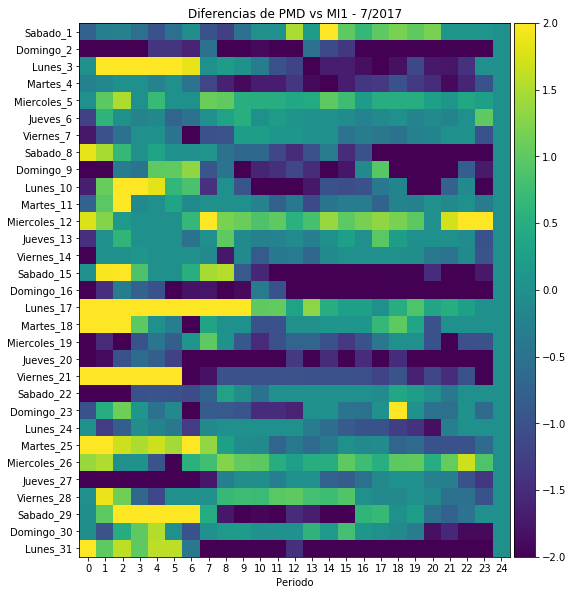

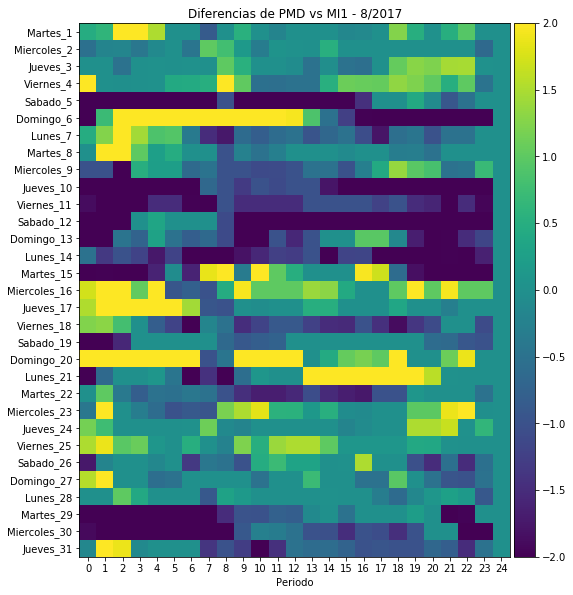

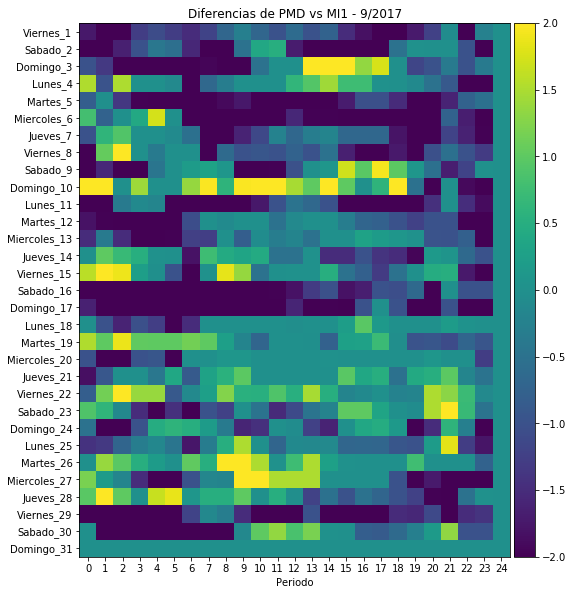

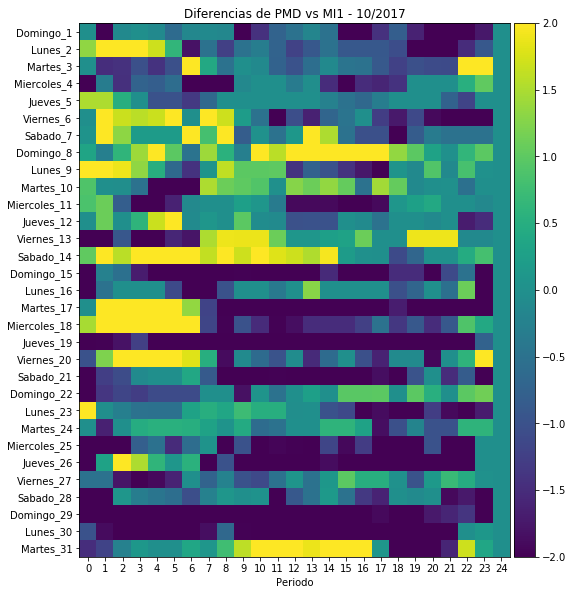

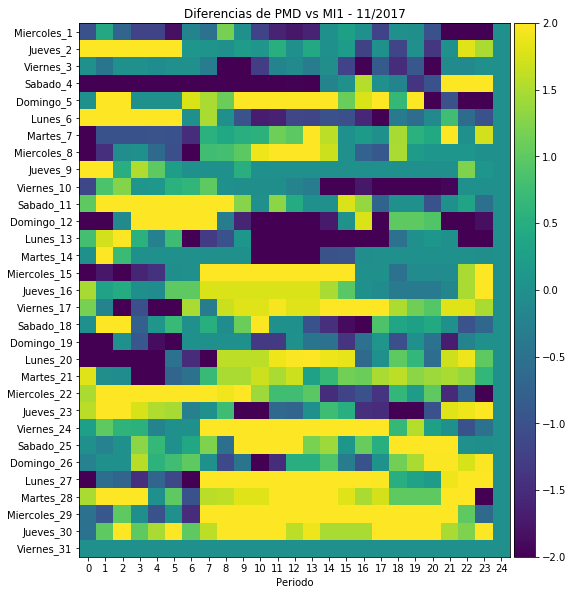

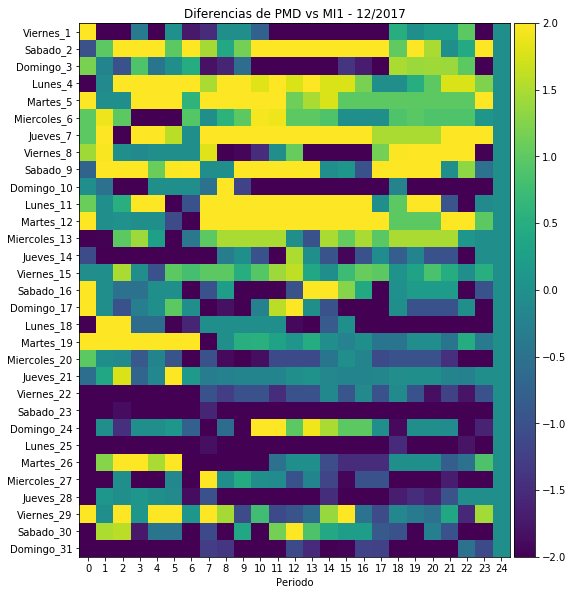

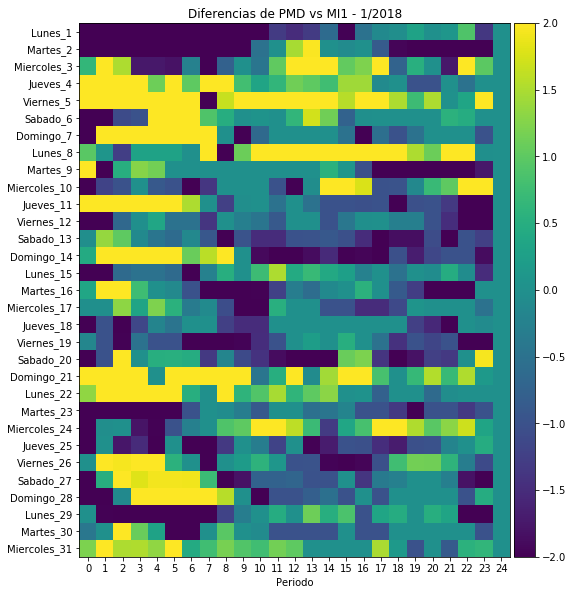

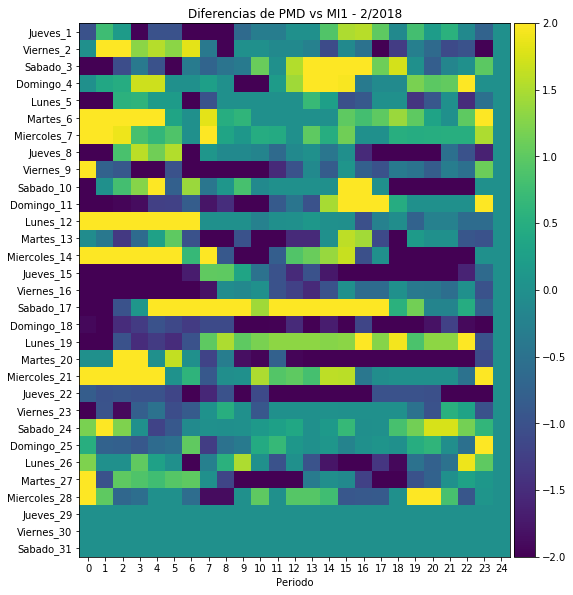

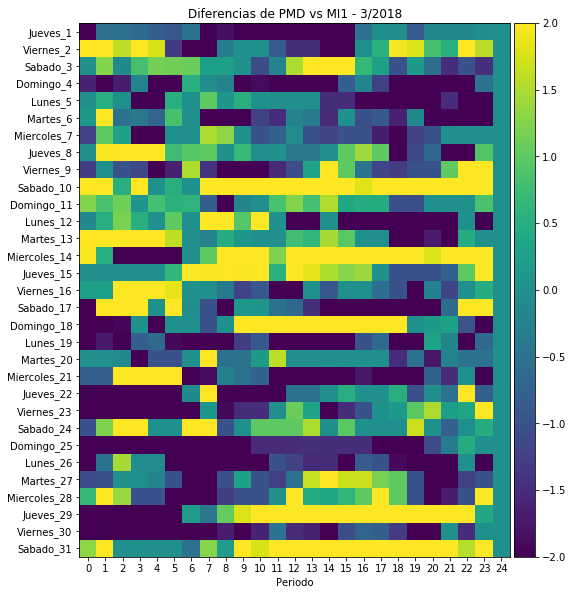

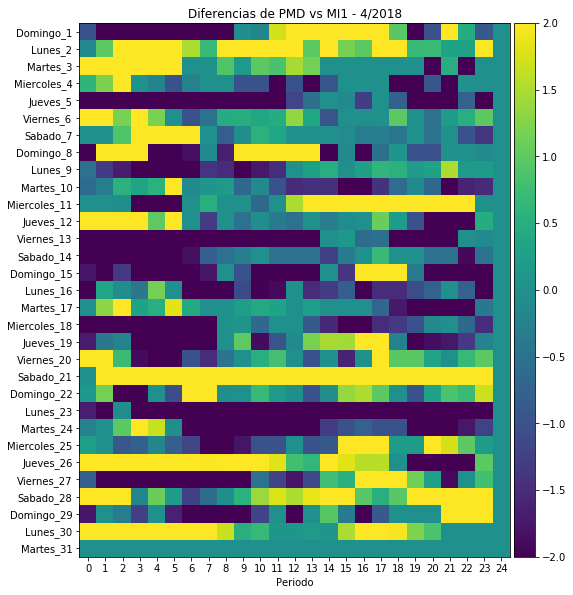

In [9]:
for year, mes in zip([2017, 2017, 2017, 2017, 2017, 2017,2017, 2017, 2018, 2018, 2018, 2018], [5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4]):
    ut.plot_heatmap_prices_diff_by_day(ut.get_prices_diff_by_day(df.reset_index(), month=mes, year=year), color_max_lim=2, color_min_lim=-2, title='Diferencias de PMD vs MI1 - {0}/{1}'.format(mes, year))

### A priori no se aprecian comportamientos repetitivos entre dias de la semana o meses, pero creemos que si identificamos un valor desde el cual la diferencia pasa a ser representativa, entonces podremos tener una mejor visualizacion de esto.

=======================================================================================================================

# Descomposicion de la diferencia de precios entre PMD y MI1 como serie temporal 

In [10]:
series = df[(df['intraday'] == 1)].set_index(pd.DatetimeIndex(df[(df['intraday'] == 1)]['datetime']))

### Para una semana

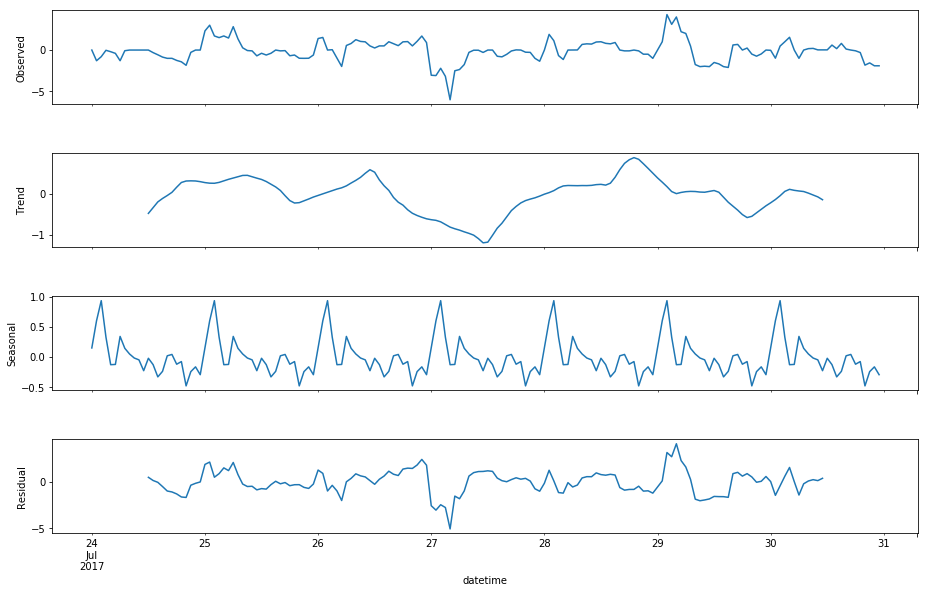

In [11]:
week = 30

x = series[series.fecha.dt.weekofyear == week]['diff_pmd_marginalES']

result = seasonal_decompose(x, model='additive')
fig = result.plot()
fig.tight_layout()
fig.set_size_inches(14, 10)
plt.show()

### Para un mes

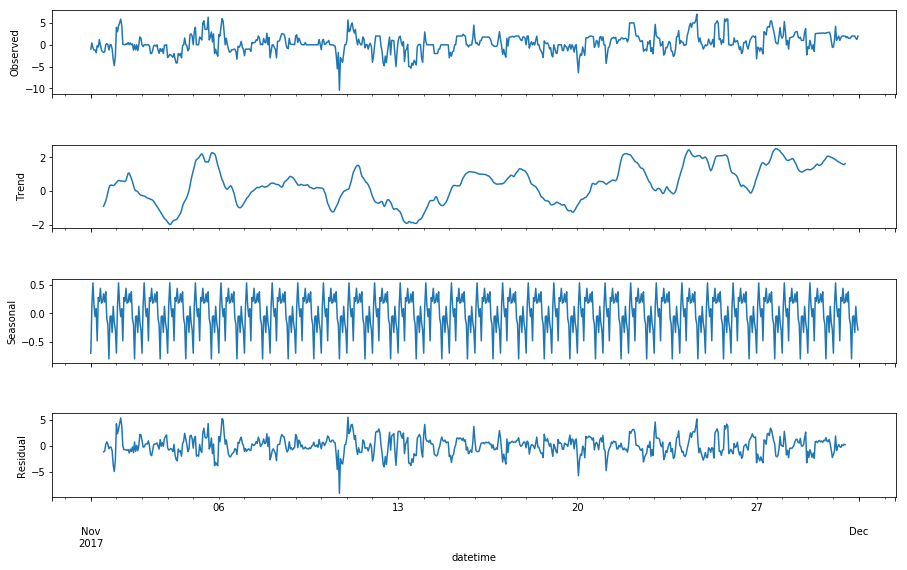

In [12]:
month = 11
year = 2017

x = series[(series['mes'] == month) & (series['year'] == year)]['diff_pmd_marginalES']
# x[x.index.duplicated(keep=False)]

result = seasonal_decompose(x, model='additive')
fig = result.plot()
fig.tight_layout()
fig.set_size_inches(14, 10)
plt.show()

Imagen de ejemplo de lo que describe cada descomposicion https://anomaly.io/wp-content/uploads/2015/12/time-series-decomposition-seasonal-trend.png

#### No se observa una tendencia marcada, el residuo es casi igual de alto que los valores observados